# **Non Homogeneous Hidden Markov Model**

In [1]:
# Importar librerías necesarias
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Habilitar conversión entre pandas y R
pandas2ri.activate()

In [2]:
from rpy2.robjects.packages import importr

# Cargar el paquete base de R
base = importr('base')

In [3]:
# Verificar conexión con R e intentar cargar un paquete
utils = importr('utils')  # Librería para gestionar paquetes en R

try:
    depmixS4 = importr('depmixS4')  # Intentar cargar depmixS4
    print("El paquete 'depmixS4' se cargó correctamente.")
except:
    print("El paquete 'depmixS4' no está instalado. Procediendo a instalar...")
    utils.install_packages('depmixS4')
    depmixS4 = importr('depmixS4')
    print("El paquete 'depmixS4' se instaló y cargó correctamente.")

El paquete 'depmixS4' se cargó correctamente.


## Library Loading and Configuration

In [4]:
import os
# os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

## Data loading and preparation:

In [5]:
covid_data = pd.read_csv('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/MAYO/covid_data_urban_quality (1).csv')

In [6]:
import pandas as pd

# 1. Cargar la base principal de COVID
covid_data = pd.read_csv('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/MAYO/covid_data_urban_quality (1).csv')

# 2. Cargar la nueva base con variables del censo actualizadas
df_soc = pd.read_excel('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/MAYO/Comunas_Variables_Actualizadas.xlsx')  # <- Cambia la ruta local si es necesario


In [7]:
df_soc=df_soc.drop(columns=['Comuna'])

In [8]:
df_soc.rename(columns={    'CUT':'Code',
                           'Población': 'Poblation',
                           'Densidad_Pob_Km2': 'Density_Pob_Km2',
                           'Total_Viviendas': 'Total_Housing',
                           'Cantidad_Hogares': 'Numbers_Households',
                           'Porc_Hacinamiento': 'Porc_Overcrowding',
                           'Promedio_Personas_Hogar': 'Average_Persons_Households',
                           'Porc_Ed_Superior_Terminada': 'Porc_Higher_Education_Completed',
                           'Porc_Hogares_con_Migrantes': 'Porc_Households_with_Immigrants'}, inplace=True)

In [9]:
covid_data = pd.merge(covid_data, df_soc, on="Code", how="left")

In [10]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants'],
      dtype='obje

In [11]:
exchange_rate_avg = (821.81 + 793.72 + 784.73 + 784.66 + 773.40 + 788.27) / 6
print(exchange_rate_avg)  # Resultado: ~792.43 CLP/USD

791.0983333333334


In [12]:
covid_data['USD_Per_Capita_Income']= covid_data['Per_Capita_Income'] / exchange_rate_avg

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.
- **'Connectivity_and_Mobility'**: Access and proximity to services associated with public transportation, level of exposure to traffic accidents and internet connection.
- **'Housing_and_Urban_Space'**: The precarious state of housing, as well as the condition of public space in terms of its maintenance and the level of insecurity in the neighborhoods.
- **'Employment_Conditions'**: Labor conditions of the resident population in terms of income, contractual conditions, cost of living and level of indebtedness.
- **'Business_Climate'**: Ability to attract economic activity and new ventures, real estate developments and new public and private services.
- **'Health_and_Ecology'**: Access and proximity to the health network, health gaps and level of environmental exposure in their environment.
- **'Socio-cultural_Factors'**: Aspects related to the development of social capital, according to the offer and results in education, citizen participation and social coexistence.
- **'Urban_Quality_of_Life_Index_2019'**: Urban Quality of Life Index 2019 of the communes.
- **'Range_ICVU'**: Range of the Urban Quality of Life Index 2019 of the communes.

In [13]:
covid_data.to_csv('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/covid_data_urban_quality_enriched.csv', index=False)

In [14]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

In [15]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants',
       'USD_Per_Ca

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.
- **'Connectivity_and_Mobility'**: Access and proximity to services associated with public transportation, level of exposure to traffic accidents and internet connection.
- **'Housing_and_Urban_Space'**: The precarious state of housing, as well as the condition of public space in terms of its maintenance and the level of insecurity in the neighborhoods.
- **'Employment_Conditions'**: Labor conditions of the resident population in terms of income, contractual conditions, cost of living and level of indebtedness.
- **'Business_Climate'**: Ability to attract economic activity and new ventures, real estate developments and new public and private services.
- **'Health_and_Ecology'**: Access and proximity to the health network, health gaps and level of environmental exposure in their environment.
- **'Socio-cultural_Factors'**: Aspects related to the development of social capital, according to the offer and results in education, citizen participation and social coexistence.
- **'Urban_Quality_of_Life_Index_2019'**: Urban Quality of Life Index 2019 of the communes.
- **'Range_ICVU'**: Range of the Urban Quality of Life Index 2019 of the communes.

## Exploratory Data Analysis (EDA):

### Gross Daily Cases with 7-day moving average:

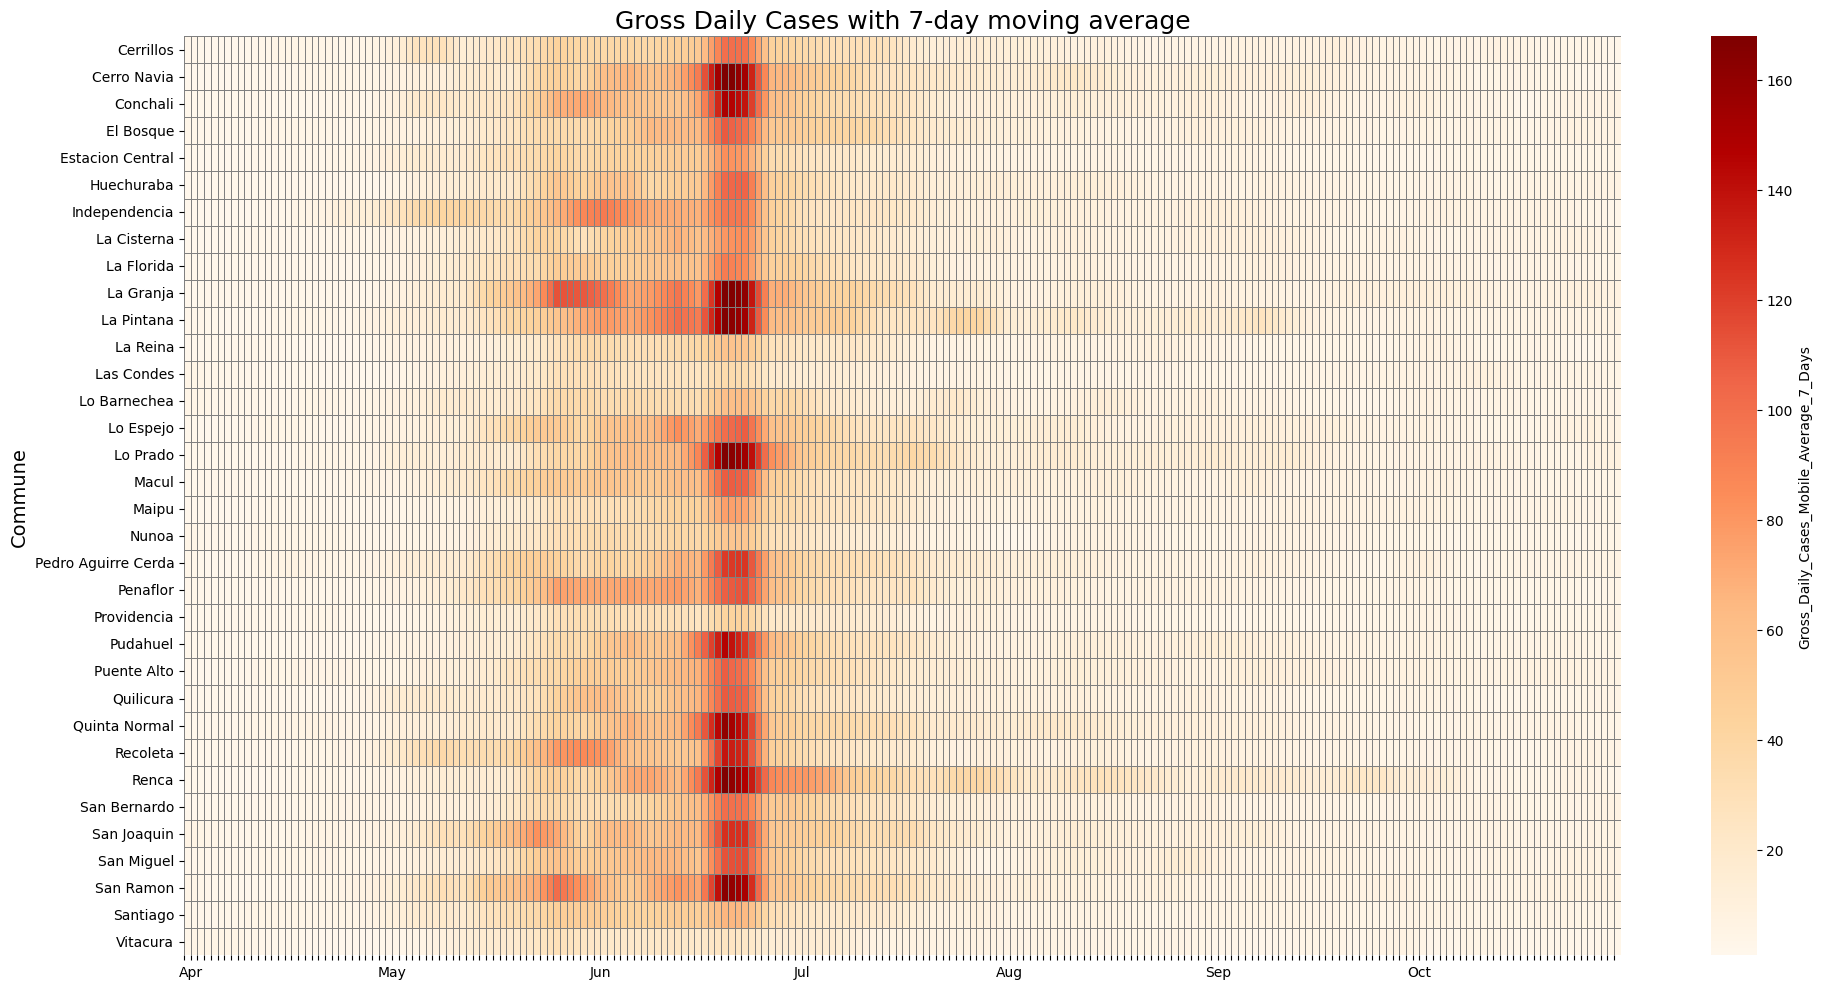

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

covid_data['Date'] = pd.to_datetime(covid_data['Date'])

# Paso 1: Convertir 'Days' a datetime si no lo es
if not pd.api.types.is_datetime64_any_dtype(covid_data['Days']):
    reference_date = covid_data['Date'].min()
    covid_data['Days'] = reference_date + pd.to_timedelta(covid_data['Days'], unit='D')


# Paso 2: Crear la tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Date', values='Gross_Daily_Cases_Mobile_Average_7_Days')

# Paso 3: Filtrar fechas

filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Valores mínimos y máximos personalizados para mejorar contraste
vmin = covid_pivot.quantile(0.05).min()  # mínimo más robusto
vmax = covid_pivot.quantile(0.95).max()  # máximo más robusto

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='OrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Gross_Daily_Cases_Mobile_Average_7_Days'},
    vmin=vmin,  # limitar escala inferior
    vmax=vmax,  # limitar escala superior
    ax=ax
)


# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Mostrar etiquetas solo para primeros días del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

plt.title('Gross Daily Cases with 7-day moving average', fontsize=18)
plt.tight_layout()
plt.show()


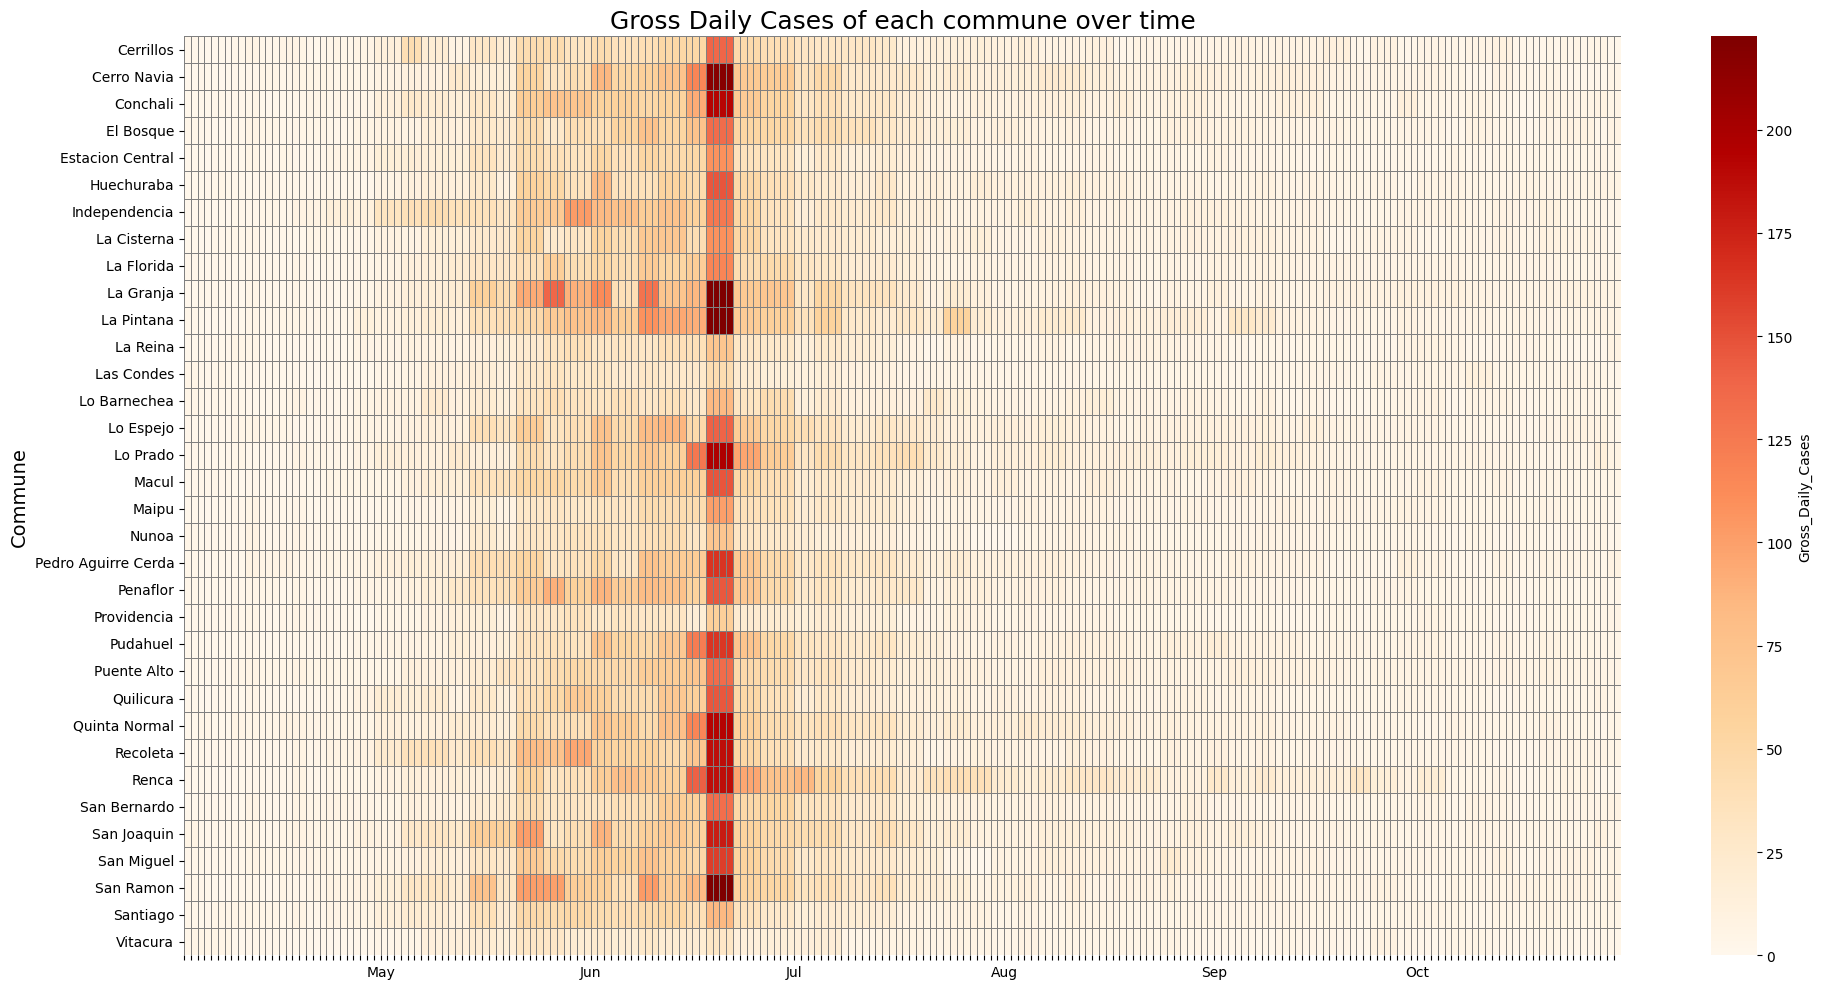

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Gross_Daily_Cases')

# Filtrar por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Valores mínimos y máximos personalizados para mejorar contraste
vmin = covid_pivot.quantile(0.05).min()  # mínimo más robusto
vmax = covid_pivot.quantile(0.95).max()  # máximo más robusto

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='OrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Gross_Daily_Cases'},
    vmin=vmin,  # limitar escala inferior
    vmax=vmax,  # limitar escala superior
    ax=ax
)

# Etiquetas
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Gross Daily Cases of each commune over time', fontsize=18)

plt.tight_layout()
plt.show()

### Internal Mobility Index of each commune over time:

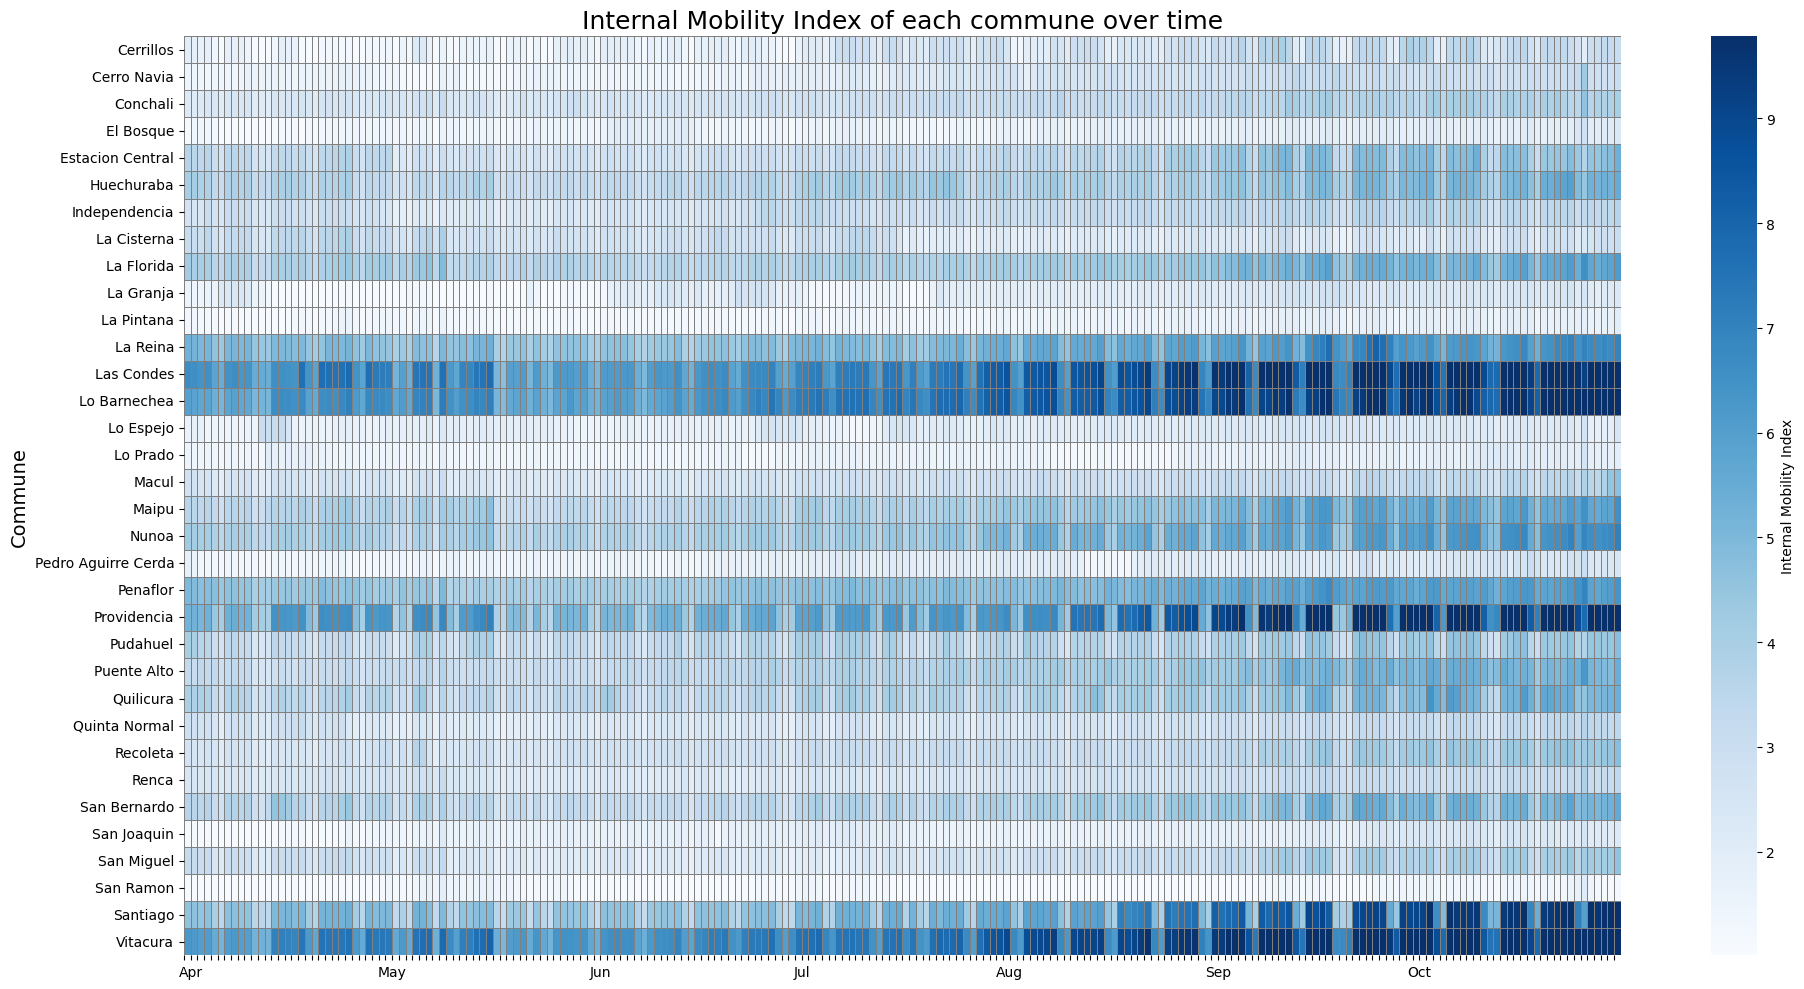

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

covid_data['Date'] = pd.to_datetime(covid_data['Date'])

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Date', values='Internal_Mobility_Index')

# Filtrar fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Blues',  # 💙 paleta azul
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Internal Mobility Index'},
    robust=True,  # 🔍 mejora el contraste sin outliers extremos
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x (solo nombre del mes en el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


### External Mobility Index of each commune over time:

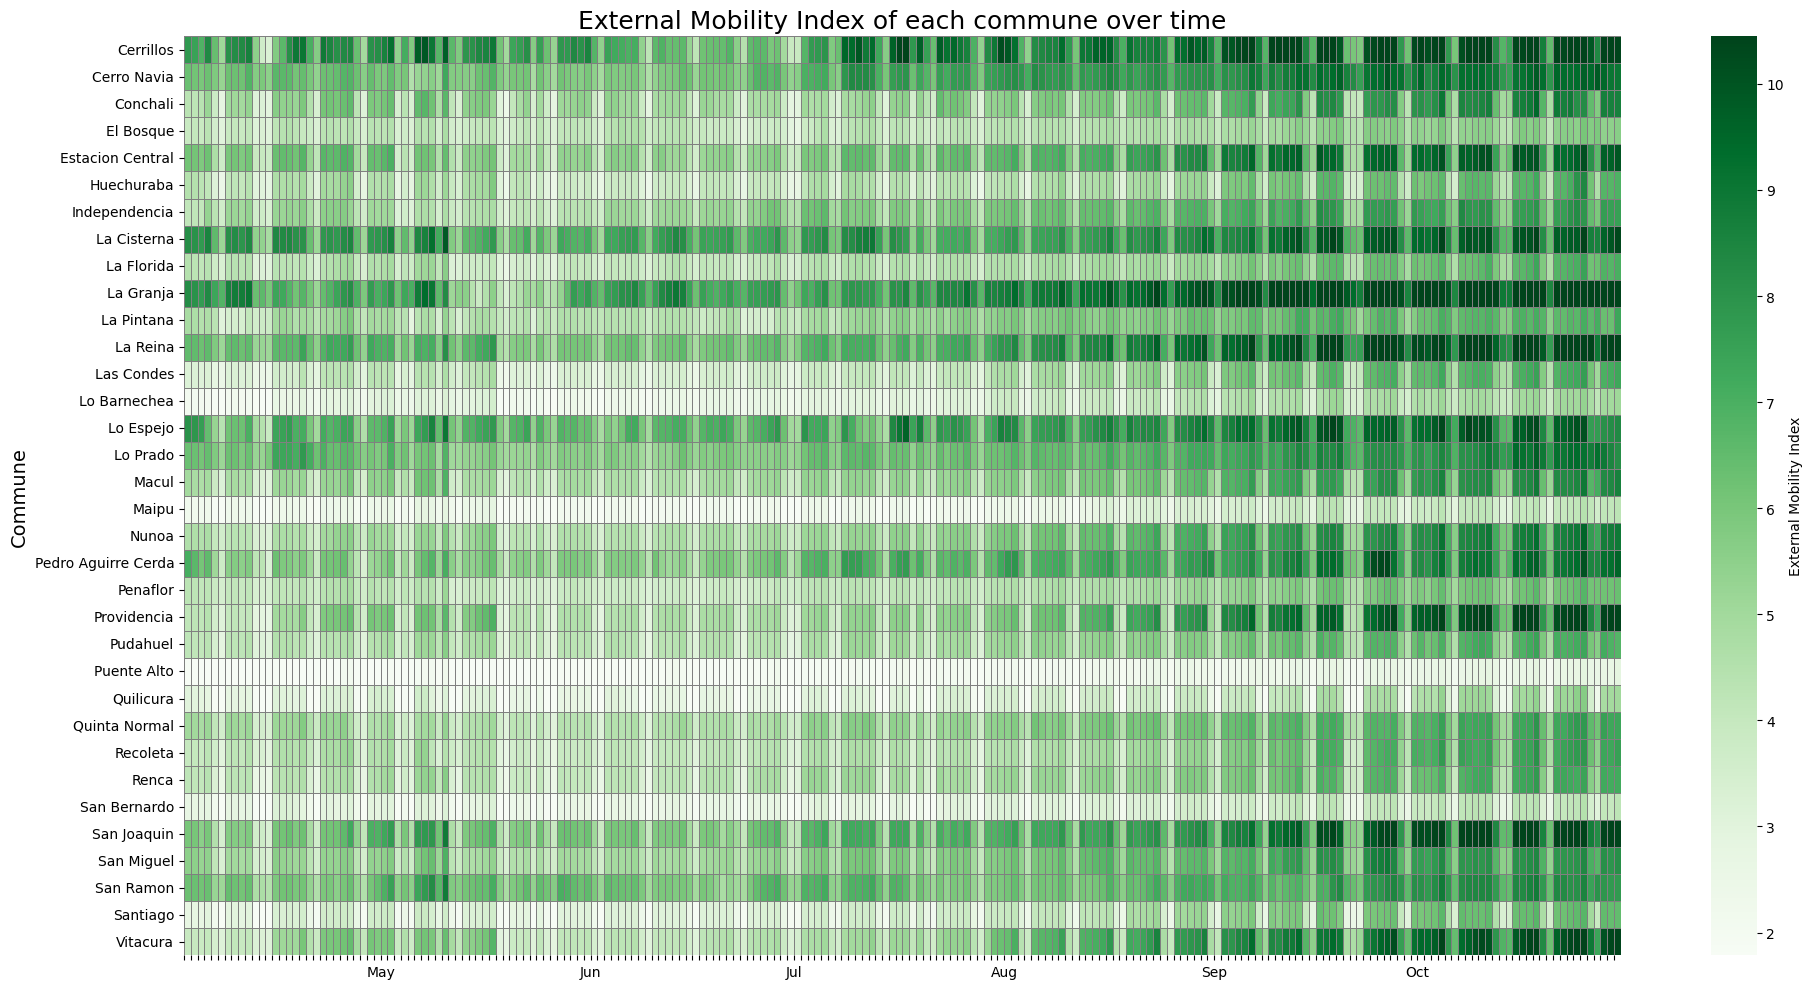

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad externa
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')

# Filtrar columnas por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greens',  # 💚 Paleta verde clara a intensa
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'External Mobility Index'},
    robust=True,  # Mejora el contraste
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x (solo el nombre del mes si es el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('External Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()

### Step by Step Plan:

In [20]:
covid_data['Step_Label'].unique()

array(['Sin Medida', 'Cuarentena', 'Transición', 'Preparación',
       'Apertura'], dtype=object)

In [21]:
# Rearrange the Step by Step_Label
remap_step = {'Sin Medida': 'Unrestricted', 'Cuarentena': 'Quarantine', 'Transición':'Transition', 'Preparación':'Preparation','Apertura':'Opening'}
covid_data['Step_Label'] = covid_data['Step_Label'].map(remap_step)

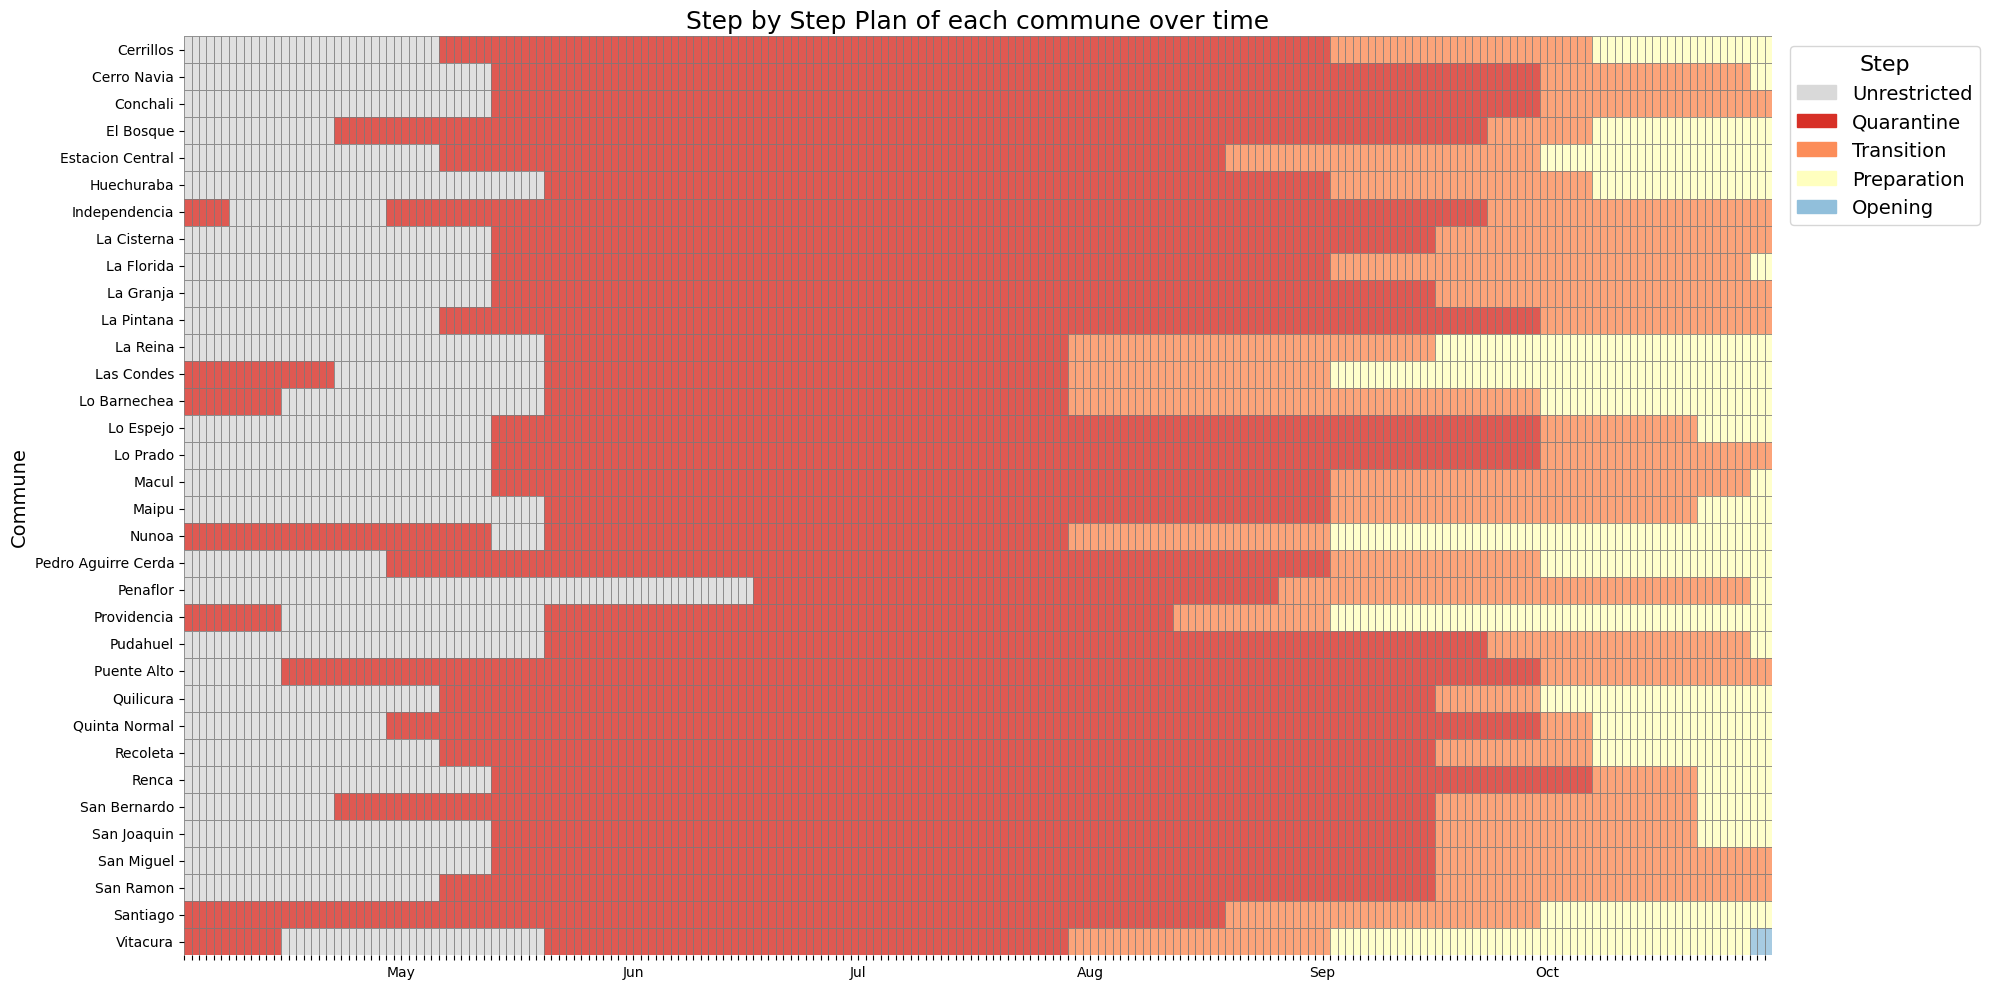

In [22]:
# Definir el rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot de los pasos
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Step')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Nueva paleta con amarillo para Preparación y azul para Apertura
step_colors = ['#d9d9d9', '#d73027', '#fc8d59', '#ffffbf', '#91bfdb']
step_labels = ['Unrestricted', 'Quarantine', 'Transition', 'Preparation', 'Opening']

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap=sns.color_palette(step_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax,
    alpha=0.8  # Ajustar la transparencia
)

# Etiquetas del eje
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: mostrar solo nombre del mes si es el primer día
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(step_colors, step_labels)
]

plt.legend(
    handles=legend_handles,
    title="Step",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Step by Step Plan of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()

## Definition of HMM model formulas:

Create `ntimes` from clean data

In [23]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


### Convert to R format:

In [24]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

The transition probabilities between states depend on the covariates ‘IM_internal’, ‘IM_external’ and the commune

In [25]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

### Creation of the HMM model:

In [26]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


## Model adjustment:

In [27]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)


converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



## Extract sequence of states (Viterbi) and join with data:

In [28]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

### Merged with the original data:

In [29]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...  Range_ICVU  Poblation  Density_Pob_Km2  \
0              

In [30]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)


## Visualizations:

### Viterbi Sequence:

In [31]:
viterbi_merged.head()

state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...  Poblation  Density_Pob_Km2  Total_Housing  \
0                   3.145581  ...      80832          4818.79          24547   
1                   3.145581  ...      80832          4818.79          24547   
2                   3.145581  ...      80832          4818.79          24547   
3                   3.145581  ...      80832          4818.79          24547   
4                   3.145581  ...      80832          4818.79          24547   

  Numbers_Households Porc_Overcrowding Average_Persons_Households  \
0              24031                 9                        3.3   
1              24031                 9                        3.3   
2              24031                 9                        3.3   
3              24031                 9                        3.3   
4              24031                 9                        3.3   

   Porc_Higher_Education_Completed  Porc_Households_with_Immigrants  \
0                               72                                7   
1                               72                                7   
2                               72                                7   
3                               72                                7   
4                               72                                7   

   USD_Per_Capita_Income Reordened_state  
0              337.75518               1  
1              337.75518               1  
2              337.75518               1  
3              337.75518               1  
4              337.75518               1  

[5 rows x 47 columns]

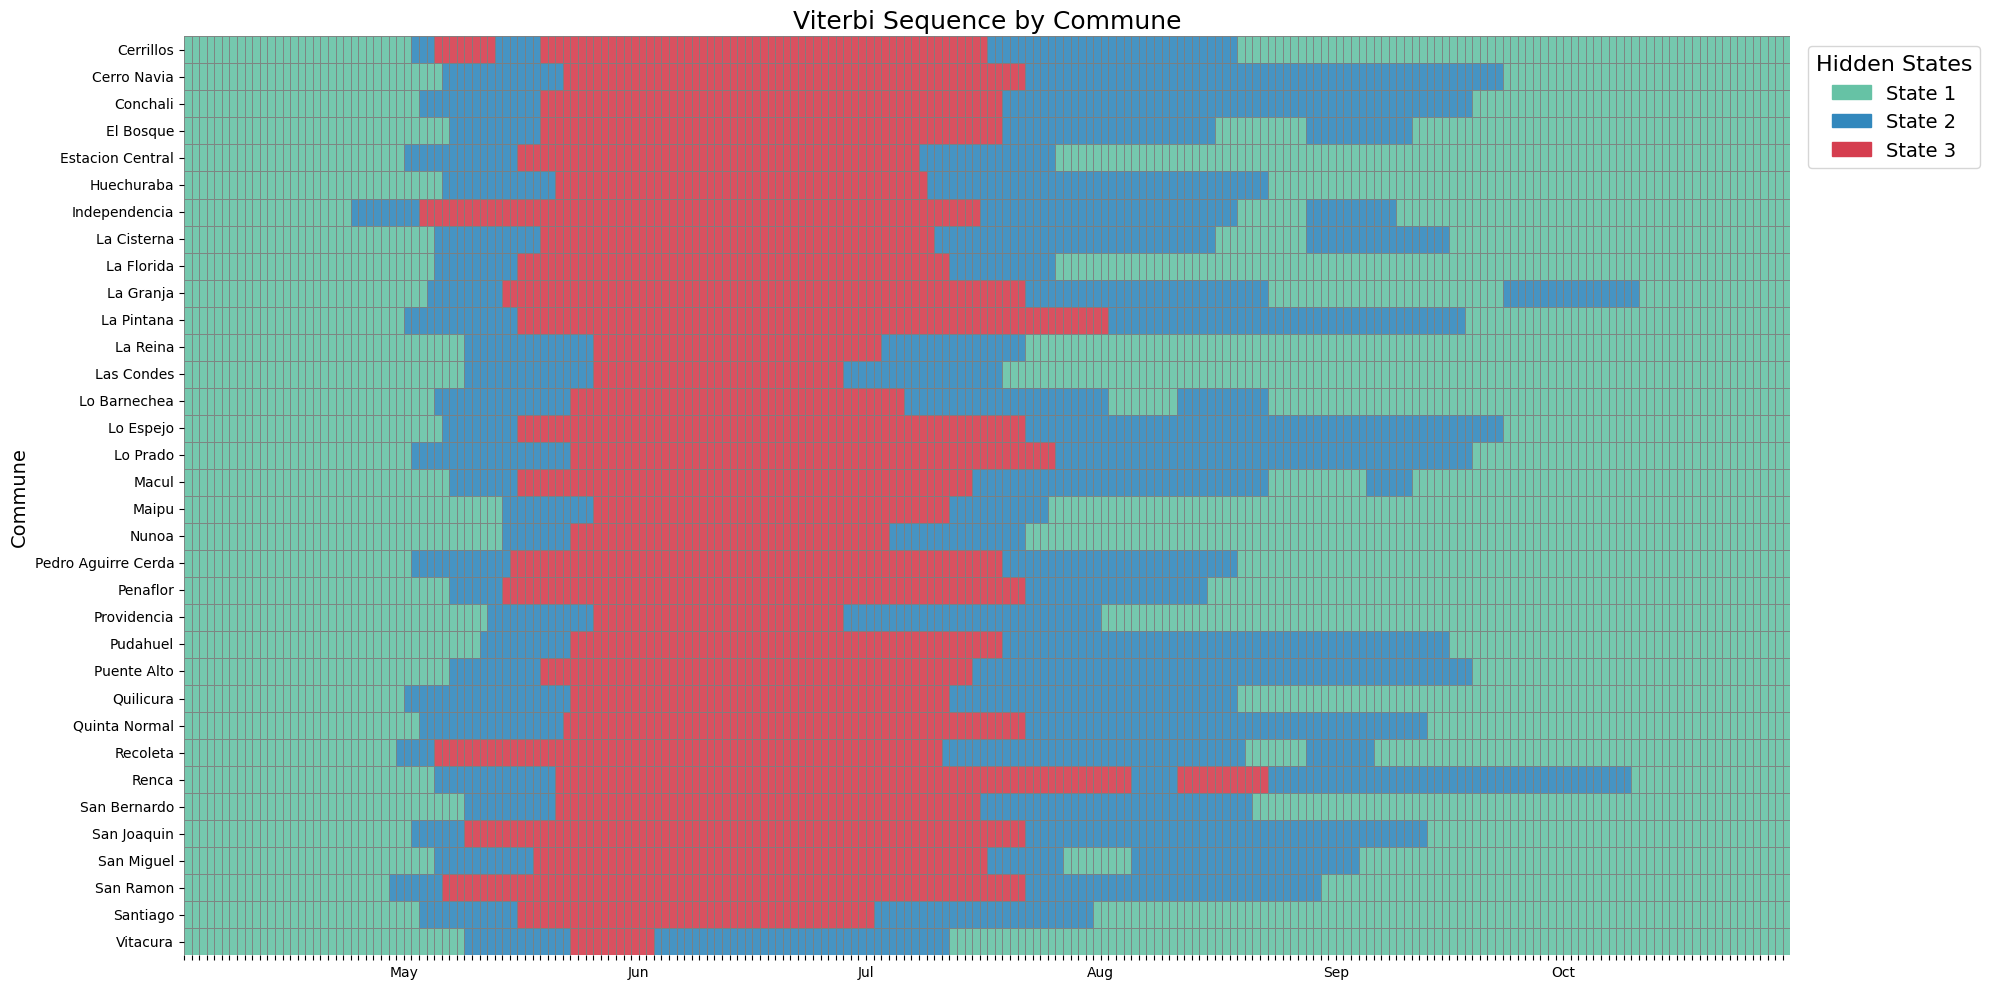

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Definir el rango de fechas a considerar
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in viterbi_pivot.columns if min_date <= col <= max_date]
viterbi_pivot = viterbi_pivot[filtered_columns]

# Colores estilo "Nature" / ColorBrewer
custom_colors = ['#66c2a5', '#3288bd', '#d53e4f']  # Estado 1, 2, 3

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Etiquetas del eje Y
ax.set_ylabel("Commune", fontsize=14)
ax.set_xlabel(None)

# Etiquetas del eje X: mostrar solo nombre del mes si es el primer día del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_labels = ['State 1', 'State 2', 'State 3']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

plt.legend(
    handles=legend_handles,
    title="Hidden States",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Viterbi Sequence by Commune', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


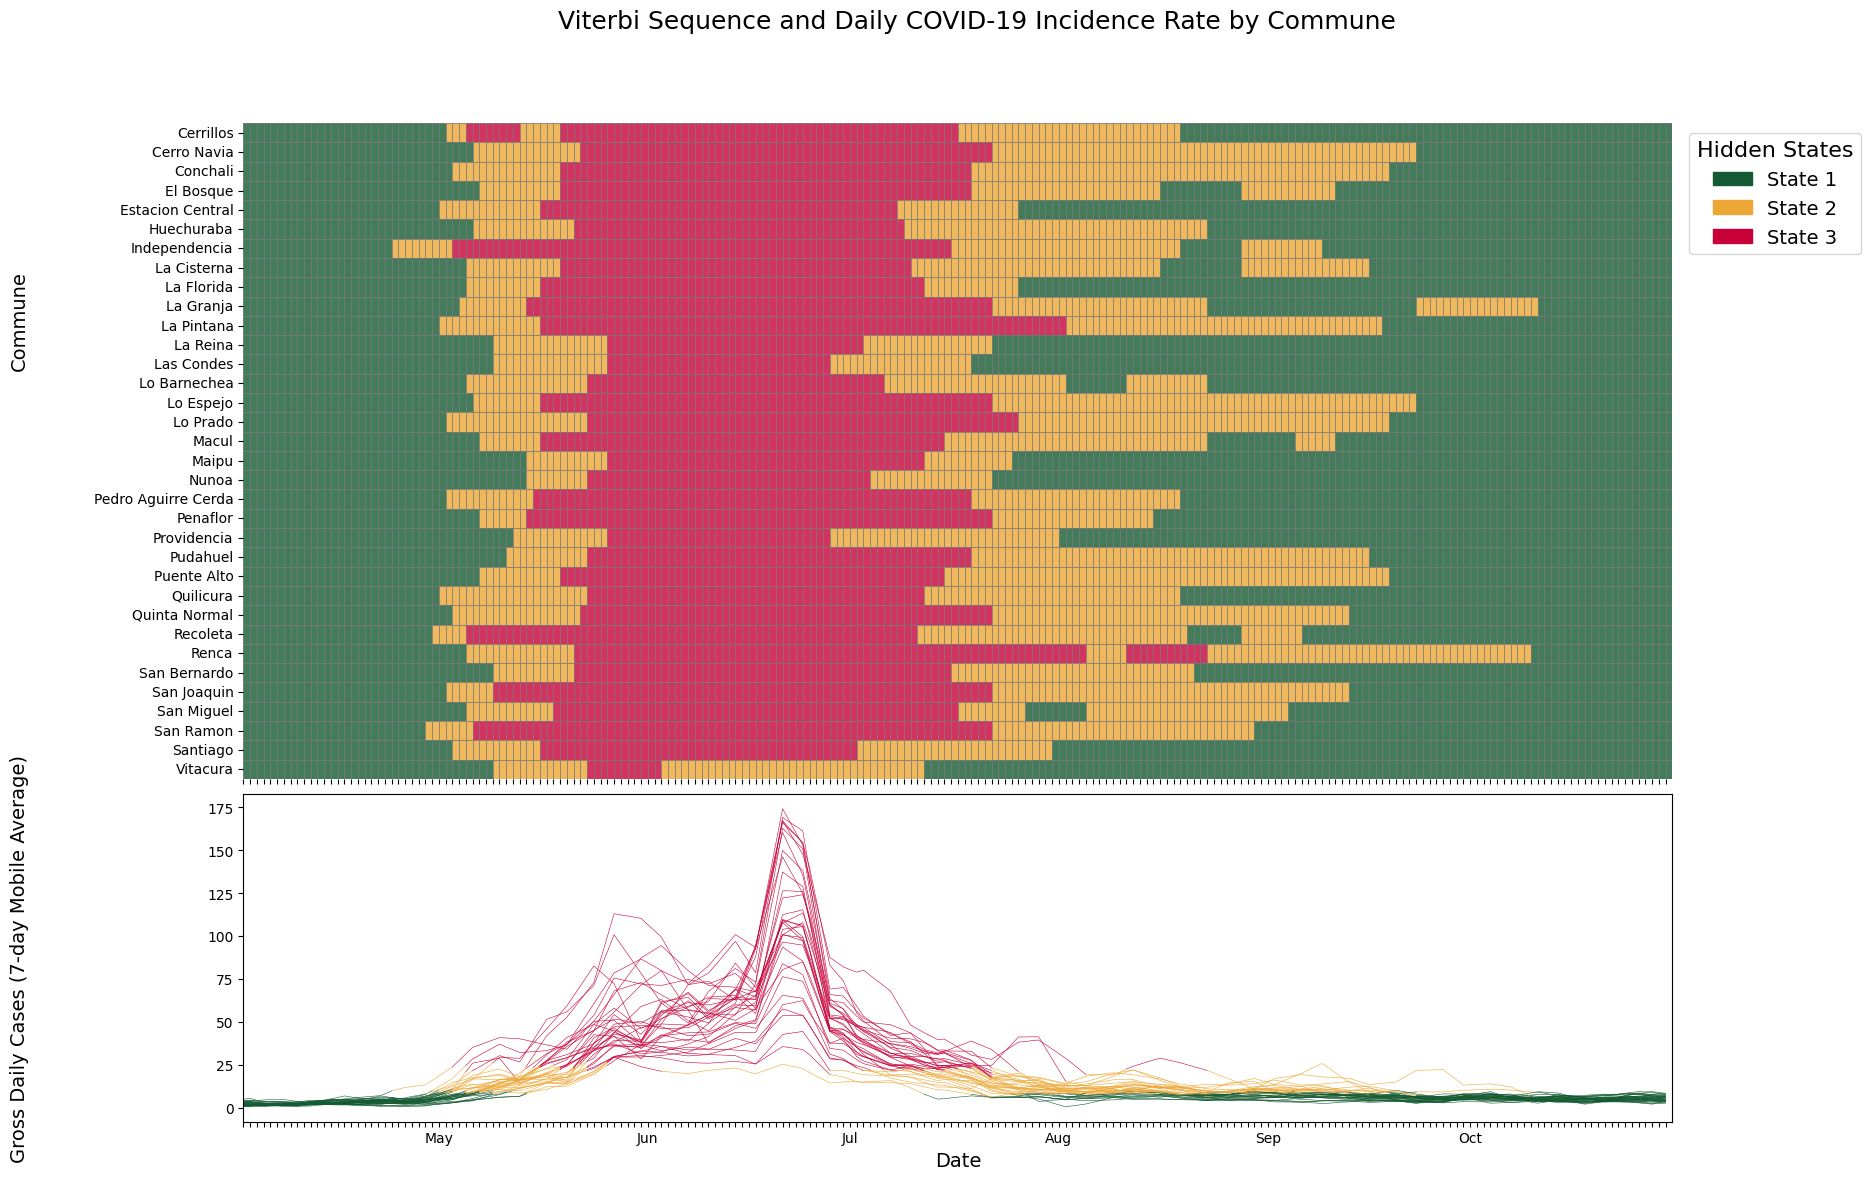

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Se asume que el DataFrame "viterbi_merged" ya está cargado.

# --- Preparación de los datos ---

# Pivot para el heatmap: filas = Commune, columnas = Days, valores = Reordened_state.
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Pivot para la serie de casos diarios usando Gross_Daily_Cases_Mobile_Average_7_Days:
# Índice = Days y columnas = Commune.
daily_cases_pivot = viterbi_merged.pivot(index='Days', columns='Commune', 
                                         values='Gross_Daily_Cases_Mobile_Average_7_Days')

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filtrar las columnas (fechas) del heatmap que están dentro del rango
filtered_columns = sorted([col for col in viterbi_pivot.columns if min_date <= col <= max_date])
viterbi_pivot = viterbi_pivot[filtered_columns]

# Filtrar la serie de casos diarios al mismo rango y reindexarla para garantizar el mismo orden de fechas
daily_cases_pivot = daily_cases_pivot.loc[min_date:max_date].reindex(filtered_columns)

# --- Configuración de colores ---
custom_colors = ['#145A32', '#eda735', '#C70039']  # Para State 1, 2, 3
#'#145A32'
#'#C70039'
#'#eda735'
#'#2166AC'
#'#B2182B'
#'grey90'

# --- Configuración de los xticks (igual que en el código original) ---
tick_positions = list(range(len(filtered_columns)))
tick_labels = [date.strftime('%b') if date.day == 1 else '' for date in filtered_columns]

# --- Crear la figura y los subplots ---
# sharex=True para que ambos subplots compartan el mismo eje X y se alineen temporalmente.
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 12), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# ===============================
# Subplot superior: Heatmap de Viterbi
# ===============================
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.4,
    linecolor='gray',
    alpha=0.8,
    cbar=False,
    ax=ax1
)
ax1.set_ylabel("Commune", fontsize=14)
ax1.yaxis.set_label_coords(-0.15, 0.7)
ax1.set_xlabel("")
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Agregar leyenda personalizada en el subplot superior
legend_labels = ['State 1', 'State 2', 'State 3']
legend_handles = [mpatches.Patch(color=color, label=label) 
                  for color, label in zip(custom_colors, legend_labels)]
ax1.legend(
    handles=legend_handles,
    title="Hidden States",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# ===============================
# Subplot inferior: Serie de casos diarios segmentada por hidden state
# ===============================
# Para cada comuna se segmenta la serie. Al detectar un cambio de estado,
# se incluye el punto de transición en ambos segmentos para lograr continuidad.
for commune in daily_cases_pivot.columns:
    x = list(range(len(filtered_columns)))  # Eje X: posiciones 0, 1, 2, ...
    y = daily_cases_pivot[commune].values
    states = viterbi_pivot.loc[commune, filtered_columns].values  # Estados correspondientes
    
    start_idx = 0
    current_state = states[0]
    for i in range(1, len(states)):
        # Al detectar un cambio de estado, incluimos el punto de transición en el segmento actual:
        if states[i] != current_state:
            ax2.plot(x[start_idx:i+1], y[start_idx:i+1],
                     color=custom_colors[int(current_state)-1], lw=0.4)
            start_idx = i
            current_state = states[i]
    # Graficar el último segmento
    ax2.plot(x[start_idx:], y[start_idx:], color=custom_colors[int(current_state)-1], lw=0.4)

# Ajuste del label del eje Y del subplot inferior para desplazarlo más a la izquierda
ax2.set_ylabel("Gross Daily Cases (7-day Mobile Average)", fontsize=14, labelpad=30)
ax2.yaxis.set_label_coords(-0.15, 0.5)

ax2.set_xlabel("Date", fontsize=14)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Eliminar leyendas en el subplot inferior, en caso de existir.
if ax2.get_legend() is not None:
    ax2.legend().remove()

# Título general del gráfico
plt.suptitle('Viterbi Sequence and Daily COVID-19 Incidence Rate by Commune', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.95, 0.93])

# Crear directorio si no existe
output_dir = "/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_FINAL"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "viterbi_daily_cases.png"), dpi=700)
plt.show()

In [34]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

# Characterization of Hidden States:

In [35]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

In [36]:
eda_data = viterbi_merged[['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index', 
                           'Cumulative_Cases_Rate', 'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                           'Per_Capita_Income', 'USD_Per_Capita_Income',
                           'Density_Pob_Km2', 'Total_Housing', 'Numbers_Households',
                           'Porc_Overcrowding', 'Housing_Precariousness_Index',
                           'Social_Priority_Index_2020', 'Poblation', 'Average_Persons_Households',
                           'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants',
                           'Employment_Conditions','Business_Climate','Connectivity_and_Mobility','Housing_and_Urban_Space',
                           'Health_and_Ecology','Socio-cultural_Factors','Urban_Quality_of_Life_Index_2019'
                              ]]

In [39]:
# Variables que queremos graficar
variables_moviles = ['Internal_Mobility_Index', 
                     'External_Mobility_Index', 
                     'Cumulative_Cases_Rate', 
                     'Gross_Daily_Cases_Mobile_Average_7_Days', 
                       ]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

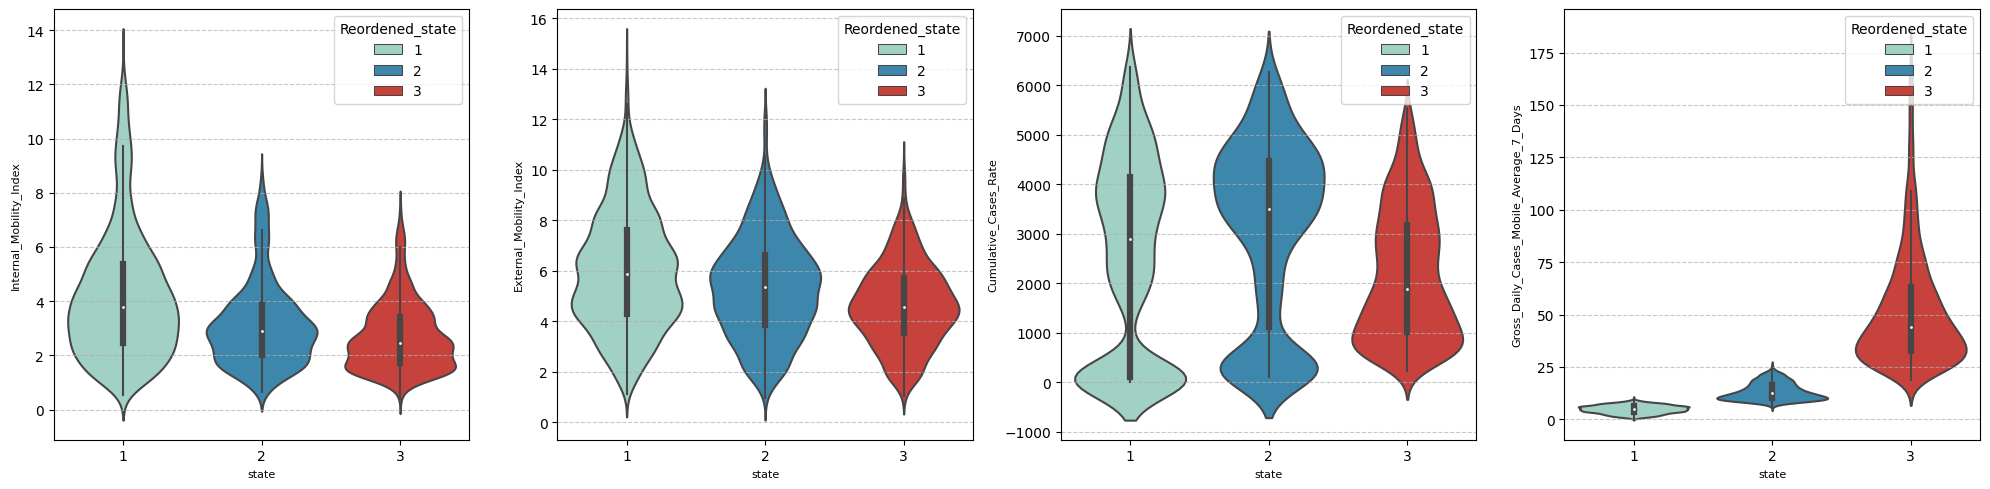

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Convertir la columna 'Reordened_state' a cadenas (string)
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#99d8c9',  # Estado 1 - leve (verde agua)
    '2': '#2b8cbe',  # Estado 2 - moderado (azul)
    '3': '#de2d26'   # Estado 3 - severo (rojo)
}

# Configuración de la figura: 1 fila y 4 columnas de subplots, tamaño total 20x5 pulgadas
n_rows = 1  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))
axes = axes.ravel()  # Aplanar el array de ejes para iterar más fácilmente

# Crear los violinplots para cada variable
# (se asume que "variables" es una lista de nombres de columnas en eda_data a graficar)
for i, var in enumerate(variables_moviles):
    sns.violinplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False
    )
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Si se desea eliminar la leyenda individual, descomentar la siguiente línea:
    # axes[i].legend_.remove()

# Eliminar cualquier subplot sobrante si hay más ejes que variables
for j in range(len(variables_moviles), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Crear directorio de salida si no existe
output_dir = "//Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_FINAL"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "violinplots.png"), dpi=700)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

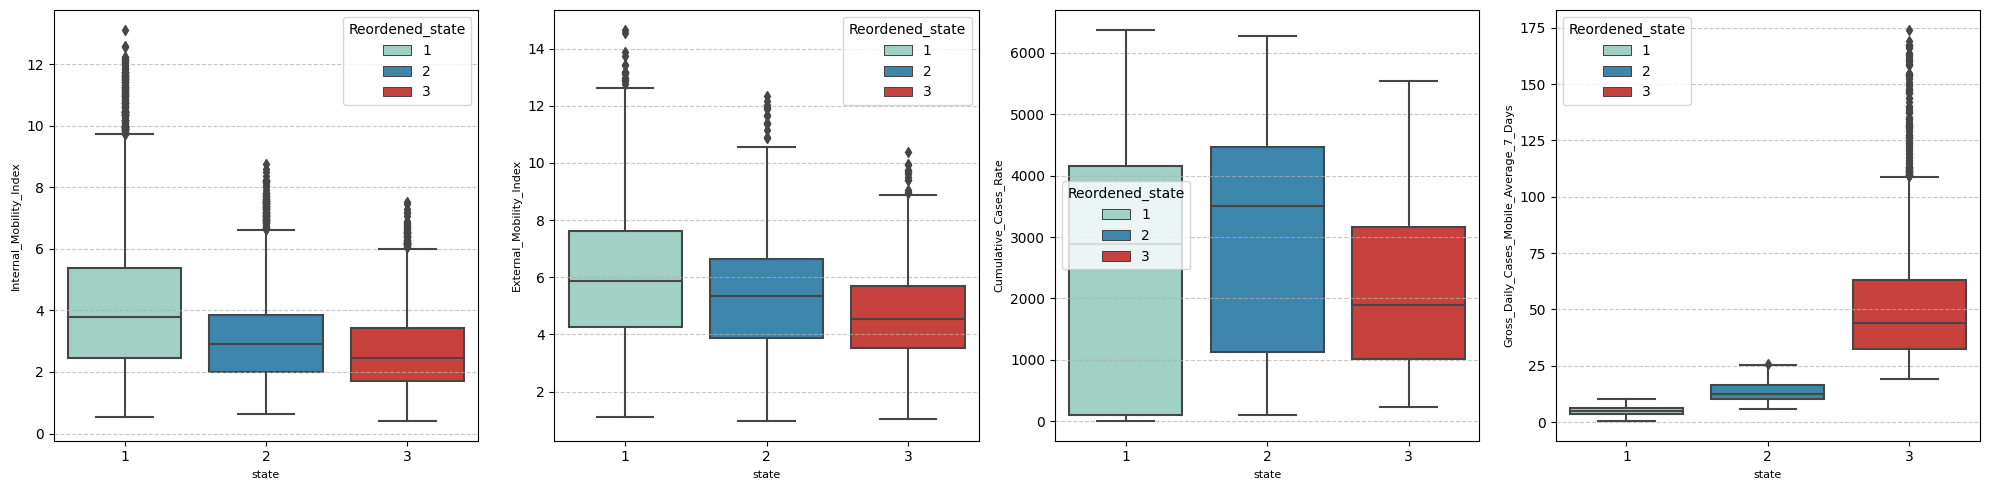

In [41]:
# Convertir la columna 'Reordened_state' a cadenas (string)
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#99d8c9',  # Estado 1 - leve (verde agua)
    '2': '#2b8cbe',  # Estado 2 - moderado (azul)
    '3': '#de2d26'   # Estado 3 - severo (rojo)
}

# Configuración de la figura: 1 fila y 4 columnas de subplots, tamaño total 20x5 pulgadas
n_rows = 1  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))
axes = axes.ravel()  # Aplanar el array de ejes para iterar más fácilmente

# Crear los violinplots para cada variable
# (se asume que "variables" es una lista de nombres de columnas en eda_data a graficar)
for i, var in enumerate(variables_moviles):
    sns.boxplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False,
        showcaps=True,  # Mostrar extremos de la caja
        showfliers=True  # Mostrar valores atípicos
    )
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Si se desea eliminar la leyenda individual, descomentar la siguiente línea:
    # axes[i].legend_.remove()

# Eliminar cualquier subplot sobrante si hay más ejes que variables
for j in range(len(variables_moviles), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Crear directorio de salida si no existe
output_dir = "//Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_FINAL"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "boxplots.png"), dpi=700)

plt.show()

In [42]:
import pandas as pd

# Lista de variables corregidas según tus columnas reales
variables_todas = [
    'Internal_Mobility_Index', 
    'External_Mobility_Index', 
    'Cumulative_Cases_Rate', 
    'Gross_Daily_Cases', 
    'Gross_Daily_Cases_Mobile_Average_7_Days', 
    'Per_Capita_Income', 
    'USD_Per_Capita_Income',
    'Density_Pob_Km2', 
    'Total_Housing', 
    'Numbers_Households',
    'Porc_Overcrowding', 
    'Housing_Precariousness_Index',
    'Social_Priority_Index_2020', 
    'Poblation', 
    'Average_Persons_Households',
    'Porc_Higher_Education_Completed', 
    'Porc_Households_with_Immigrants',
    'Employment_Conditions',
    'Business_Climate',
    'Connectivity_and_Mobility',
    'Housing_and_Urban_Space',
    'Health_and_Ecology',
    'Socio-cultural_Factors',
    'Urban_Quality_of_Life_Index_2019'
]

# Calcular los estadígrafos por estado oculto
summary_stats = []

for var in variables_todas:
    stats = eda_data.groupby('Reordened_state')[var].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
        lambda x: x.quantile(0.75) - x.quantile(0.25)
    ])
    stats.columns = ['n', 'media', 'mediana', 'DE', 'mínimo', 'máximo', 'Q1', 'Q3', 'RIC']
    stats['variable'] = var
    summary_stats.append(stats)

# Unir resultados
summary_df = pd.concat(summary_stats).reset_index()

# Reordenar columnas para claridad
summary_df = summary_df[['variable', 'Reordened_state', 'n', 'media', 'mediana', 'DE', 'mínimo', 'Q1', 'Q3', 'RIC', 'máximo']]

# Mostrar tabla final
summary_df


variable Reordened_state     n      media  \
0            Internal_Mobility_Index               1  3493   4.236591   
1            Internal_Mobility_Index               2  1834   3.150077   
2            Internal_Mobility_Index               3  1949   2.698699   
3            External_Mobility_Index               1  3493   6.011209   
4            External_Mobility_Index               2  1834   5.347341   
..                               ...             ...   ...        ...   
67            Socio-cultural_Factors               2  1834  34.868719   
68            Socio-cultural_Factors               3  1949  35.332417   
69  Urban_Quality_of_Life_Index_2019               1  3493  55.722703   
70  Urban_Quality_of_Life_Index_2019               2  1834  52.550480   
71  Urban_Quality_of_Life_Index_2019               3  1949  51.847245   

      mediana         DE     mínimo         Q1         Q3        RIC  \
0    3.780322   2.390730   0.544551   2.459249   5.367826   2.908577   
1    2.895794   1.557867   0.635662   2.002545   3.855405   1.852860   
2    2.455210   1.254624   0.403075   1.706218   3.432145   1.725927   
3    5.856697   2.353286   1.123766   4.269280   7.613976   3.344696   
4    5.343473   2.003800   0.965216   3.856956   6.631038   2.774083   
..        ...        ...        ...        ...        ...        ...   
67  35.460000  13.464786   4.660000  26.020000  43.680000  17.660000   
68  36.130000  13.350501   4.660000  27.480000  43.680000  16.200000   
69  55.090000   9.962419  38.080000  48.540000  61.920000  13.380000   
70  51.110000   9.314962  38.080000  46.700000  55.860000   9.160000   
71  51.000000   8.355015  38.080000  46.700000  55.860000   9.160000   

       máximo  
0   13.124657  
1    8.749661  
2    7.512220  
3   14.662443  
4   12.328743  
..        ...  
67  58.280000  
68  58.280000  
69  75.590000  
70  75.590000  
71  75.590000  

[72 rows x 11 columns]

In [43]:
state_count = viterbi_merged.groupby(['Commune', 'Reordened_state']).size().reset_index(name='Days')

In [44]:
state_count[state_count['Commune']=='Vitacura'].sort_values(by='Days', ascending=False)

Commune  Reordened_state  Days
99   Vitacura                1   150
100  Vitacura                2    53
101  Vitacura                3    11

In [45]:
state_count[state_count['Commune']=='La Pintana'].sort_values(by='Days', ascending=False)

Commune  Reordened_state  Days
32  La Pintana                3    78
30  La Pintana                1    74
31  La Pintana                2    62

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.fram

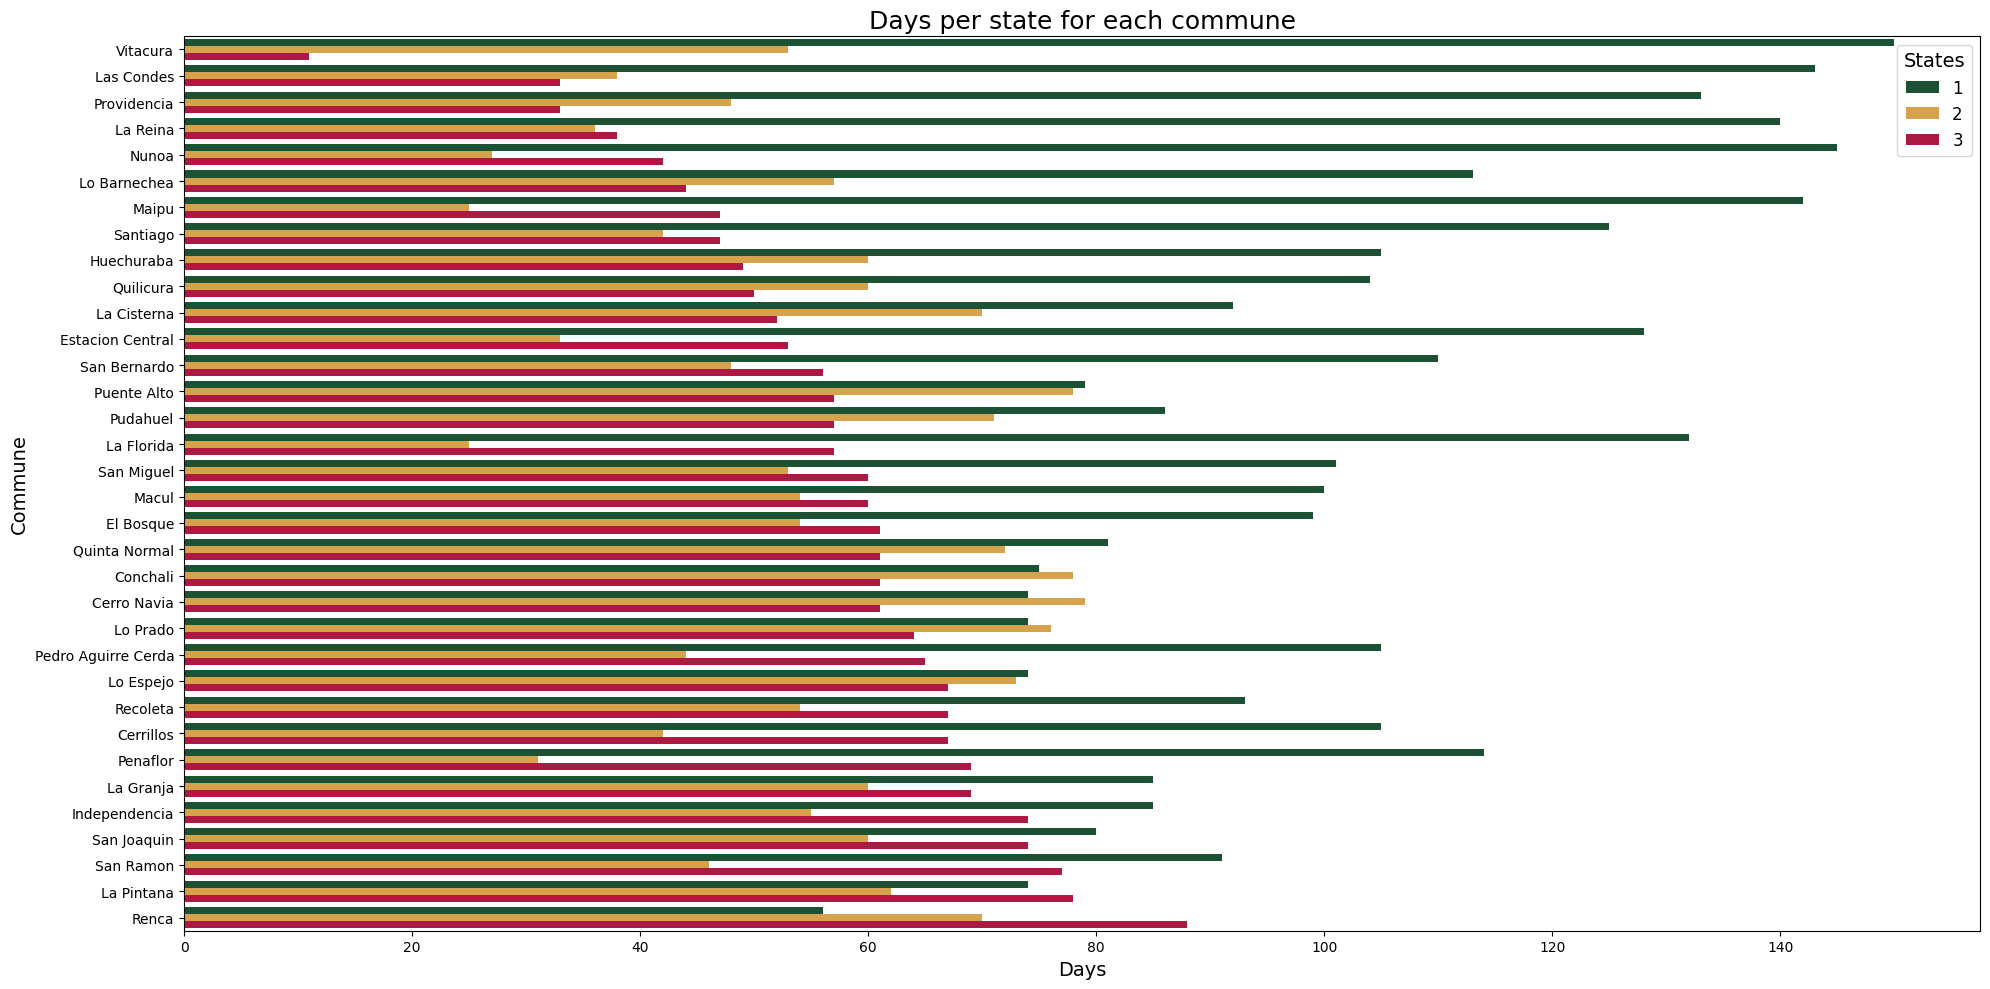

In [46]:
# Aggregate the data to count the total "Days" for state 3 (Reordened_state == 3) per commune
state_3_counts = state_count[state_count['Reordened_state'] == 3].groupby('Commune')['Days'].sum().sort_values()

# Use the sorted order of communes in the state_count DataFrame
sorted_communes = state_3_counts.index

# Sort the original data frame by this order
state_count_sorted = state_count.copy()
state_count_sorted['Commune'] = pd.Categorical(state_count_sorted['Commune'], categories=sorted_communes, ordered=True)
state_count_sorted = state_count_sorted.sort_values('Commune')

# Create the barplot:
plt.figure(figsize=(20, 10))
custom_palette = {
    '1': '#145A32',  # Estado 1 - leve (verde agua)
    '2': '#eda735',  # Estado 2 - moderado (azul)
    '3': '#C70039'   # Estado 3 - severo (rojo)
}
custom_colors = ['#145A32', '#eda735', '#C70039']  # Light gray, medium gray, and dark gray

sns.barplot(
    data=state_count_sorted, 
    x='Days', 
    y='Commune', 
    orient='h', 
    hue='Reordened_state', 
    palette=custom_colors, 
    dodge=True
)

# Add title, labels, and legend
plt.title('Days per state for each commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)
plt.xticks()
plt.legend(title='States', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

In [47]:
eda_data.columns

Index(['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index',
       'Cumulative_Cases_Rate', 'Gross_Daily_Cases',
       'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
       'USD_Per_Capita_Income', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding',
       'Housing_Precariousness_Index', 'Social_Priority_Index_2020',
       'Poblation', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants',
       'Employment_Conditions', 'Business_Climate',
       'Connectivity_and_Mobility', 'Housing_and_Urban_Space',
       'Health_and_Ecology', 'Socio-cultural_Factors',
       'Urban_Quality_of_Life_Index_2019'],
      dtype='object')

In [48]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

## Regresiones Lineales Cantidad de Días por Estado con cada Variable Sociodemográfica por si sola

### Definición data cantidad de días por estado

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Preparación de los datos
days_by_state = (
    viterbi_merged
    .groupby(['Commune', 'Reordened_state'])['Date']
    .count()
    .reset_index(name='Days_in_State')
    .pivot(index='Commune', columns='Reordened_state', values='Days_in_State')
    .rename(columns={1: 'Days_State_1', 2: 'Days_State_2', 3: 'Days_State_3'})
    .fillna(0)
)


In [50]:
socio_vars = viterbi_merged.groupby('Commune')[[
    'Internal_Mobility_Index', 
    'External_Mobility_Index', 
    'Cumulative_Cases_Rate', 
    'Gross_Daily_Cases', 
    'Gross_Daily_Cases_Mobile_Average_7_Days', 
    'Per_Capita_Income', 
    'USD_Per_Capita_Income',
    'Density_Pob_Km2', 
    'Total_Housing', 
    'Numbers_Households',
    'Porc_Overcrowding', 
    'Housing_Precariousness_Index',
    'Social_Priority_Index_2020', 
    'Poblation', 
    'Average_Persons_Households',
    'Porc_Higher_Education_Completed', 
    'Porc_Households_with_Immigrants',
    'Employment_Conditions',
    'Business_Climate',
    'Connectivity_and_Mobility',
    'Housing_and_Urban_Space',
    'Health_and_Ecology',
    'Socio-cultural_Factors',
    'Urban_Quality_of_Life_Index_2019'
]].mean()

In [51]:
df = days_by_state.join(socio_vars).reset_index()

### Cantidad de días por estado con Ingreso Per Cápita USD

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1163600766.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1163600766.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1163600766.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

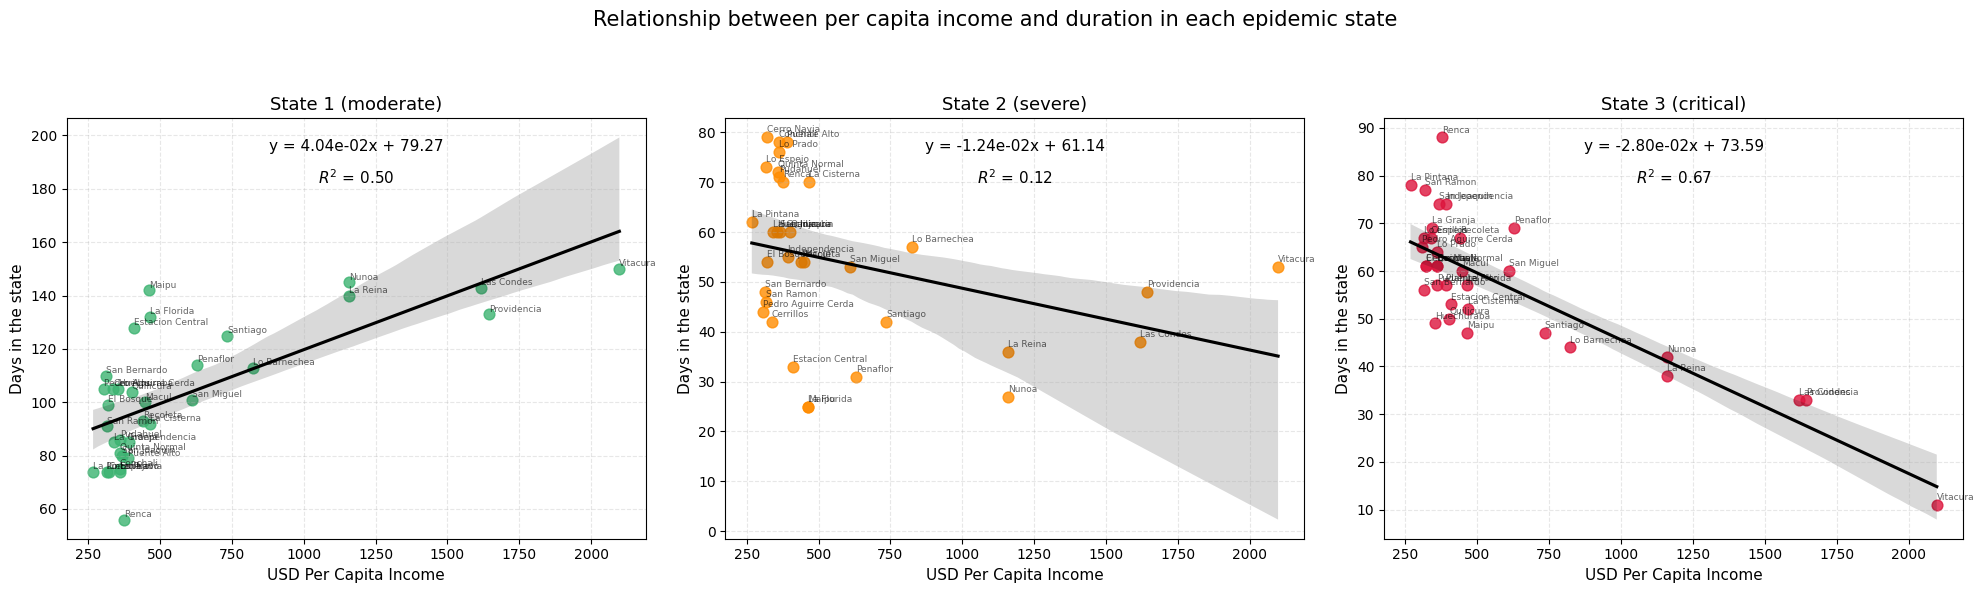

In [52]:
# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['USD_Per_Capita_Income']
    y = df[y_col]

    # Ajuste de regresión lineal con OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2e}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='USD_Per_Capita_Income',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['USD_Per_Capita_Income'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Anotaciones centradas
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("USD Per Capita Income", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between per capita income and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Índice Precariedad de la Vivienda

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3721843209.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3721843209.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3721843209.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

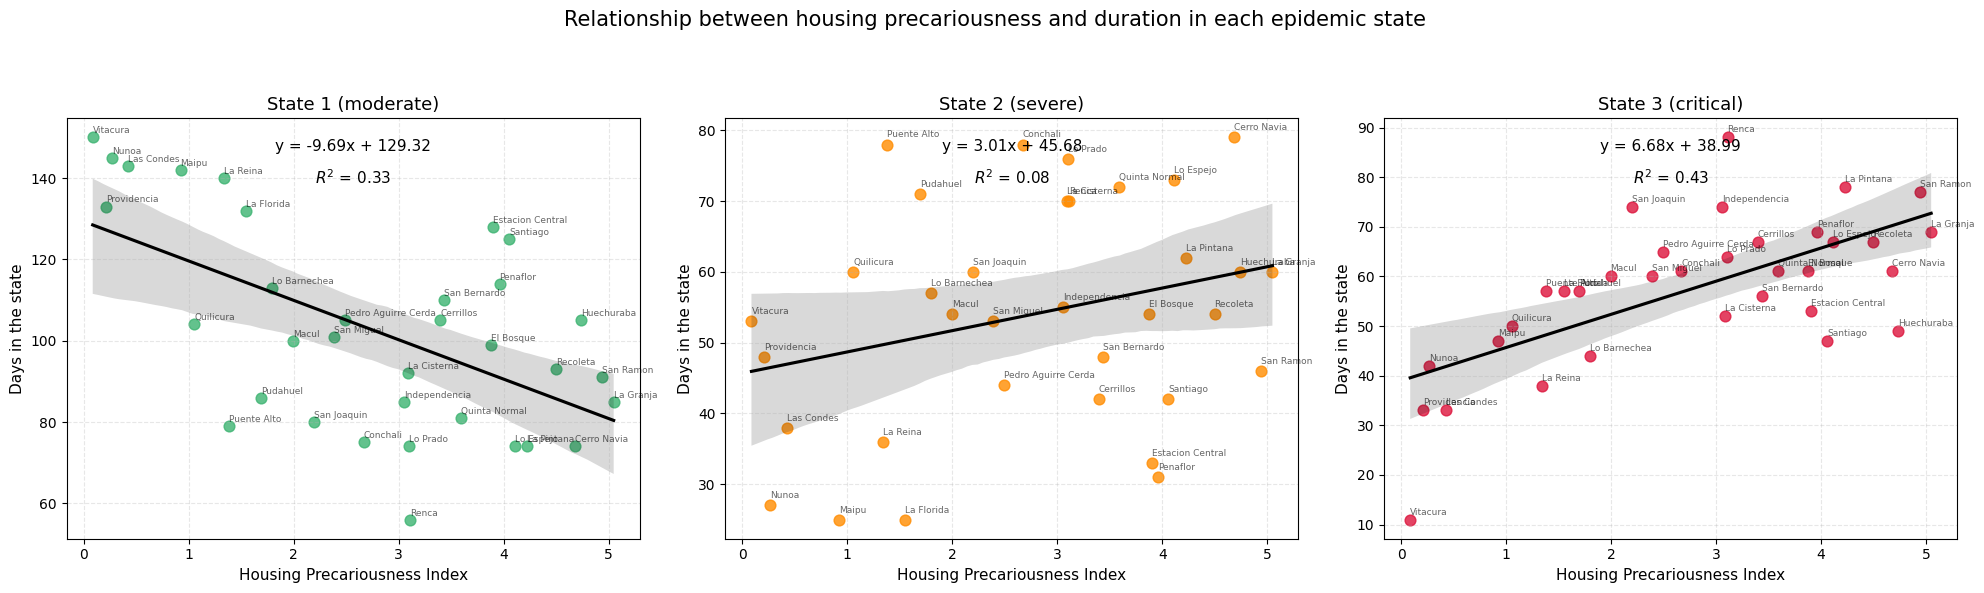

In [53]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Housing_Precariousness_Index']
    y = df[y_col]

    # Ajuste de regresión lineal con statsmodels
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico con línea de regresión
    sns.regplot(
        data=df,
        x='Housing_Precariousness_Index',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Housing_Precariousness_Index'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Anotaciones centradas
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y etiquetas
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("Housing Precariousness Index", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between housing precariousness and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Índice de Prioridad Social

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/2660551418.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/2660551418.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/2660551418.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

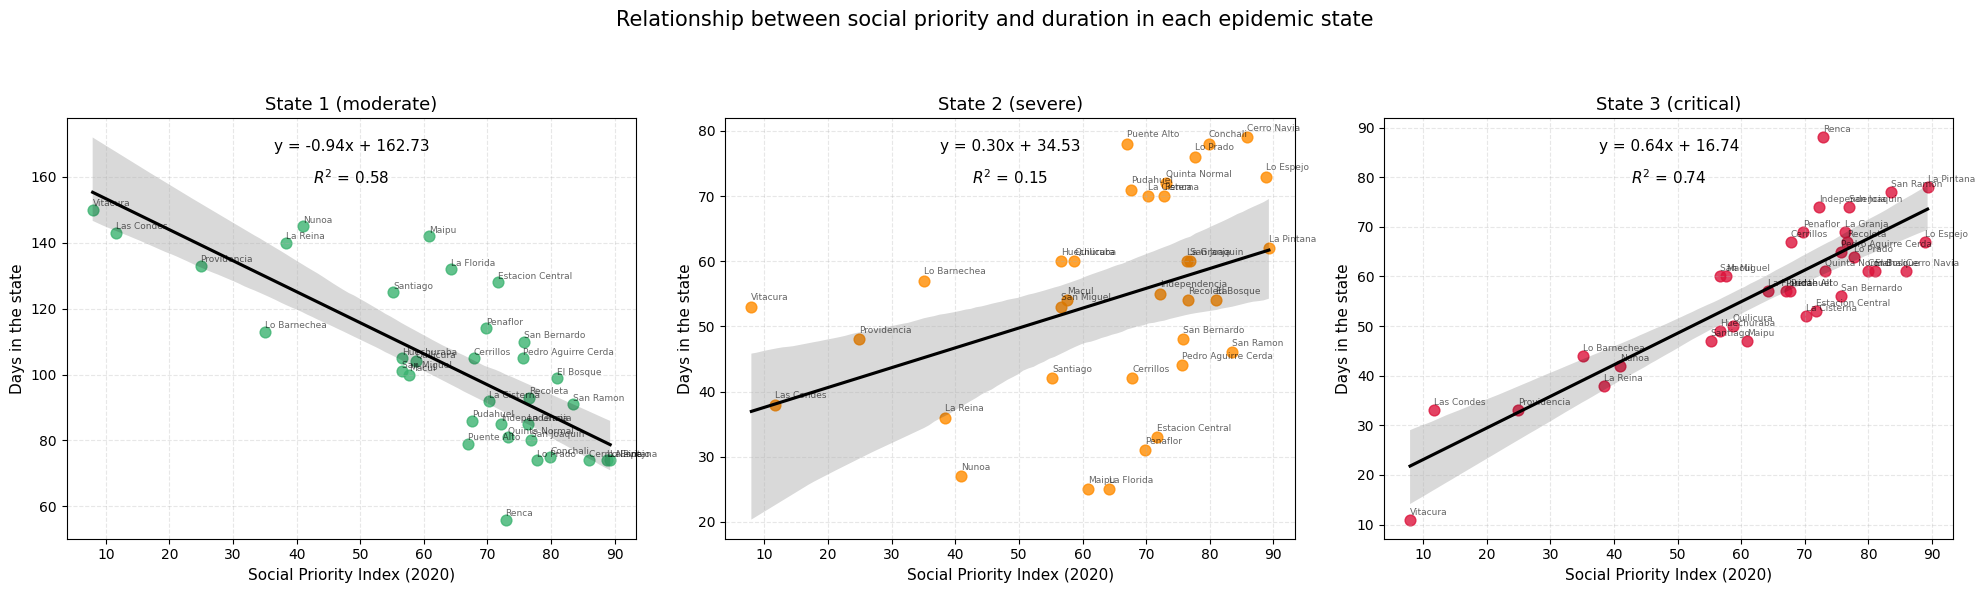

In [54]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Social_Priority_Index_2020']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Social_Priority_Index_2020',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Social_Priority_Index_2020'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("Social Priority Index (2020)", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between social priority and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Porcentaje Hacinamiento

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/772315786.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/772315786.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/772315786.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

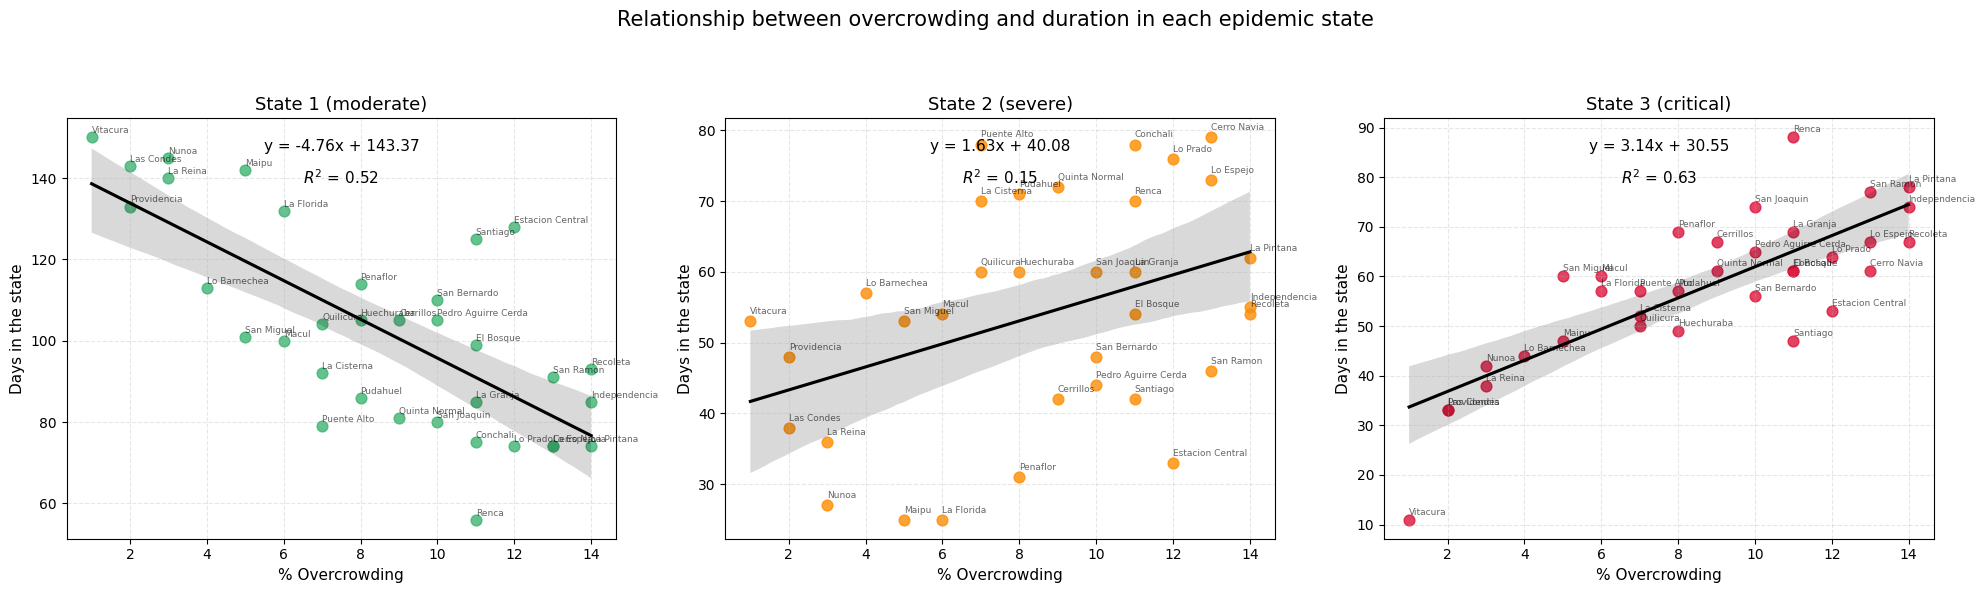

In [55]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Porc_Overcrowding']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Porc_Overcrowding',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Porc_Overcrowding'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("% Overcrowding", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between overcrowding and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Porcentaje Inmigrantes

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/212309682.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/212309682.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/212309682.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

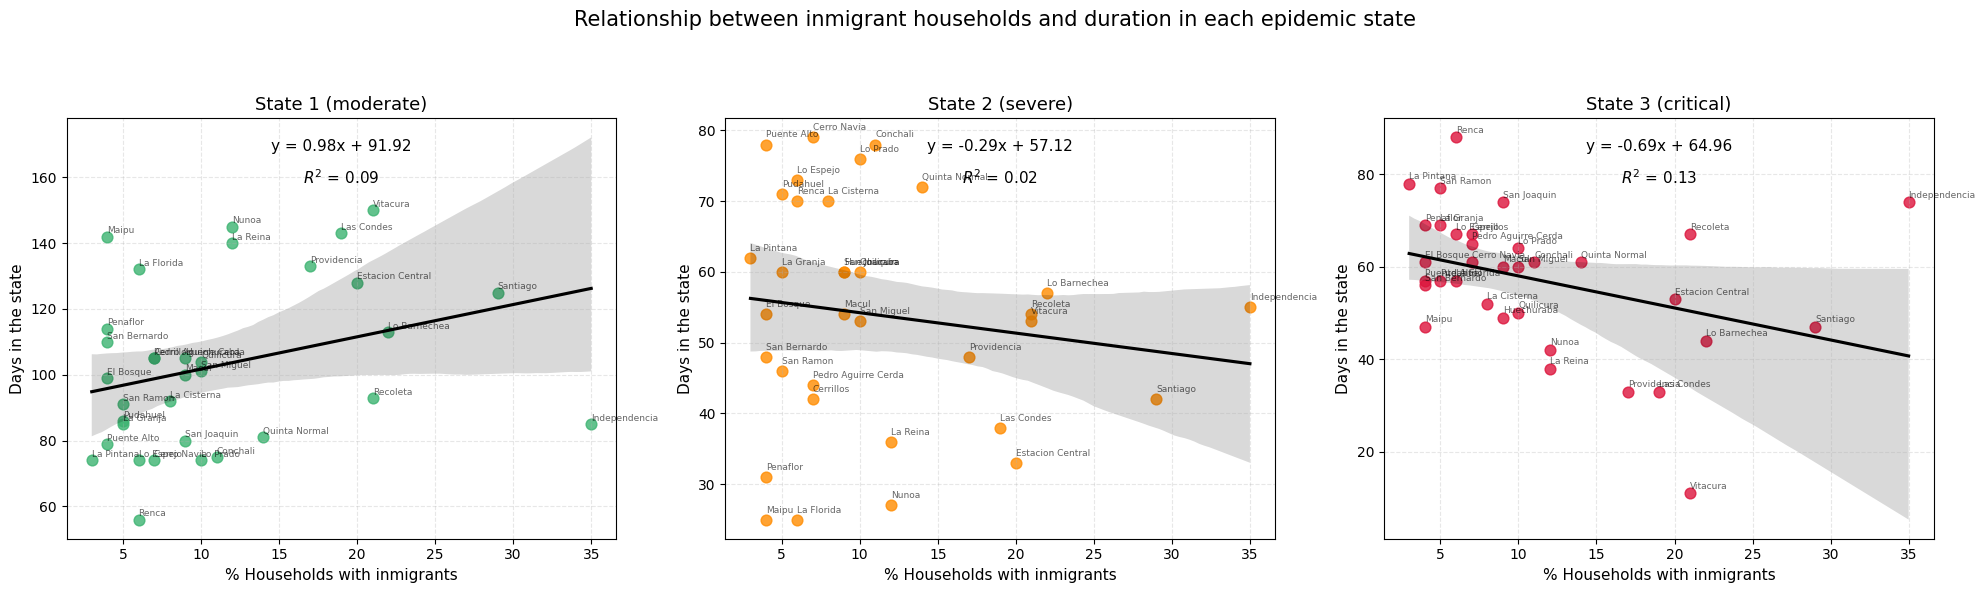

In [56]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Porc_Households_with_Immigrants']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Porc_Households_with_Immigrants',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Porc_Households_with_Immigrants'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("% Households with inmigrants", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between inmigrant households and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Porcentaje Educación Superior Terminada

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1252969468.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1252969468.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1252969468.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

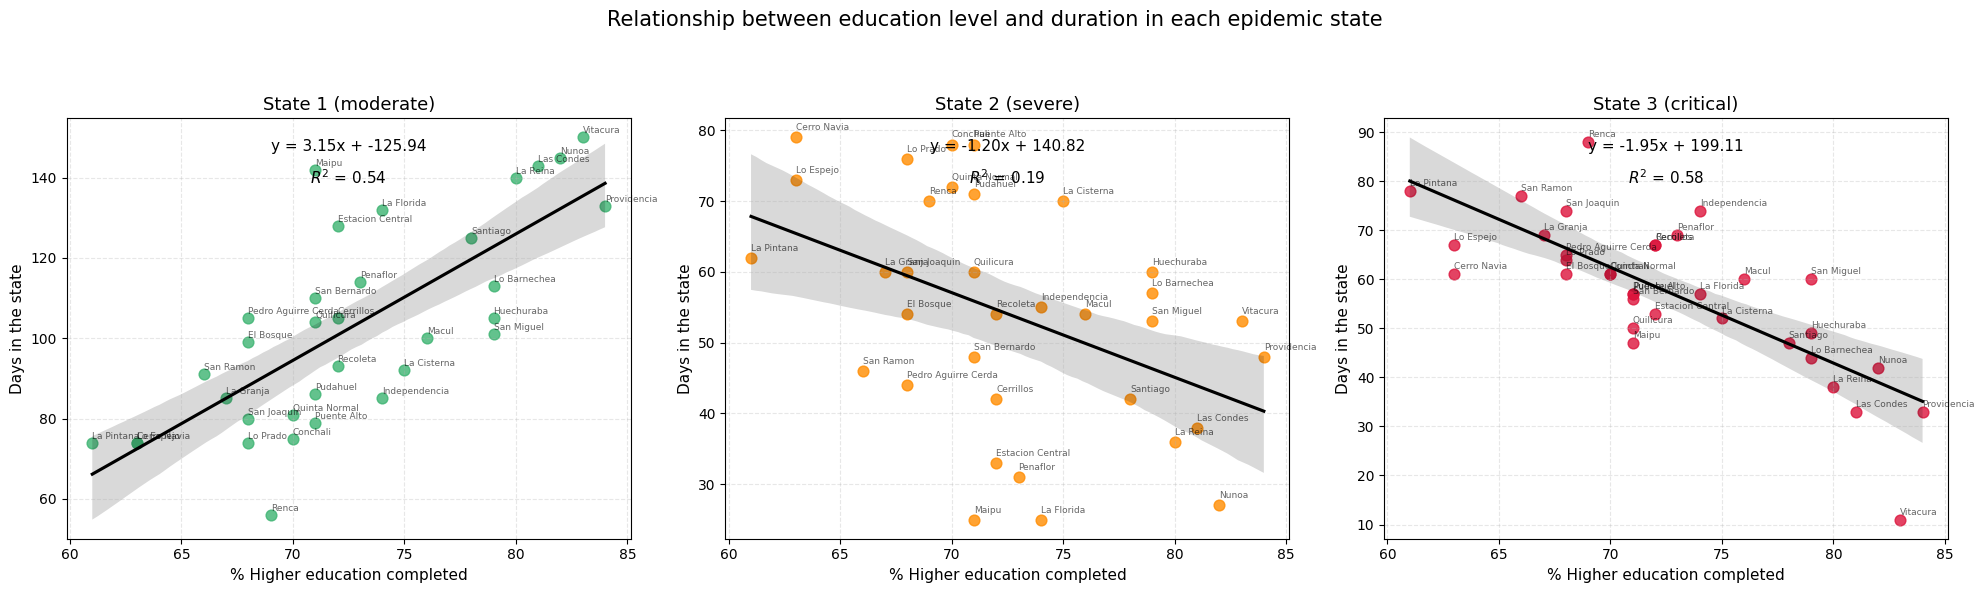

In [57]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Porc_Higher_Education_Completed']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Porc_Higher_Education_Completed',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Porc_Higher_Education_Completed'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("% Higher education completed", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between education level and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Densidad Poblacional

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/132266322.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/132266322.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/132266322.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

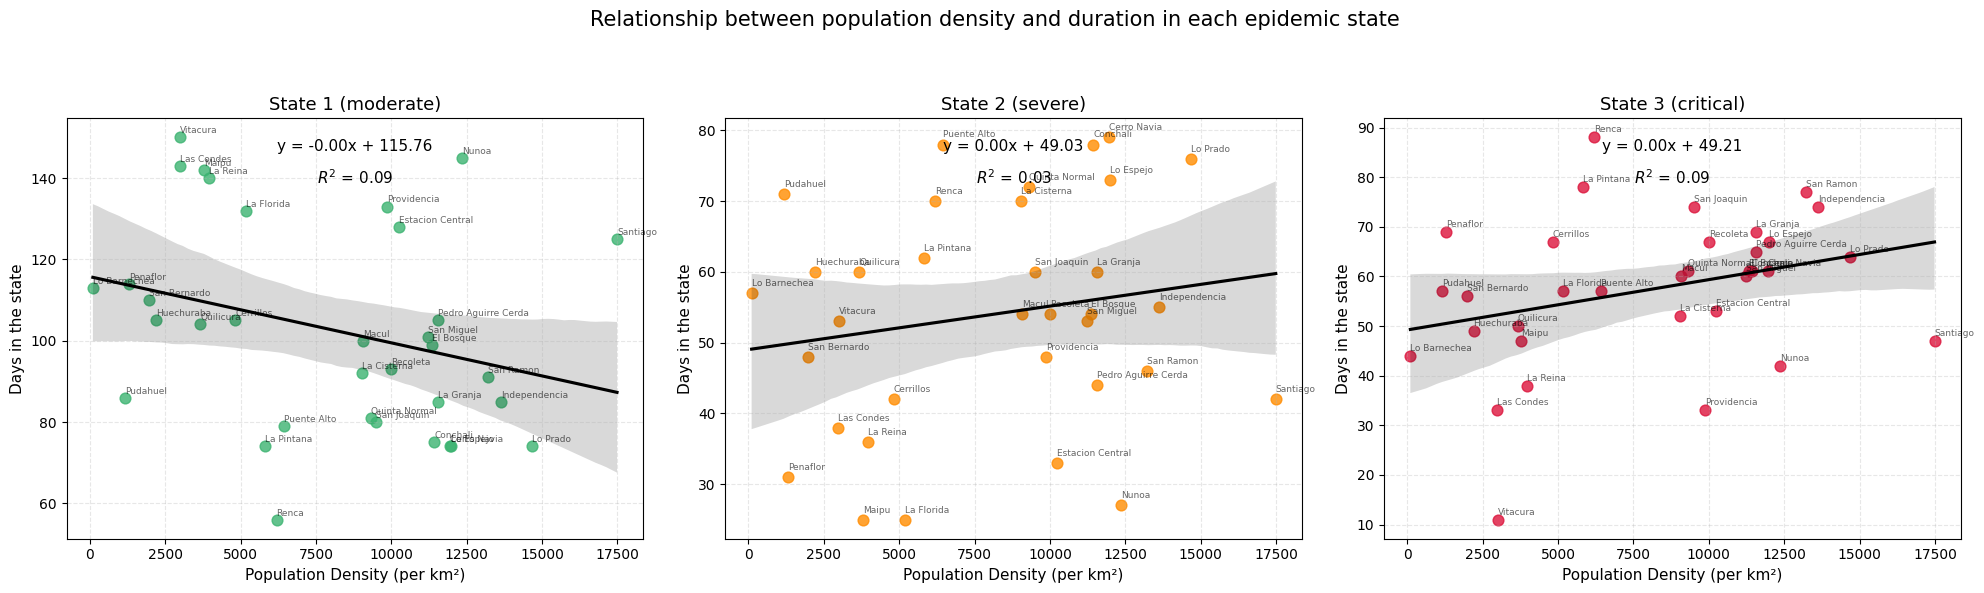

In [58]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Density_Pob_Km2']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Density_Pob_Km2',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Density_Pob_Km2'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("Population Density (per km²)", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between population density and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Promedio Personas por Hogar

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/4207461354.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/4207461354.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/4207461354.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

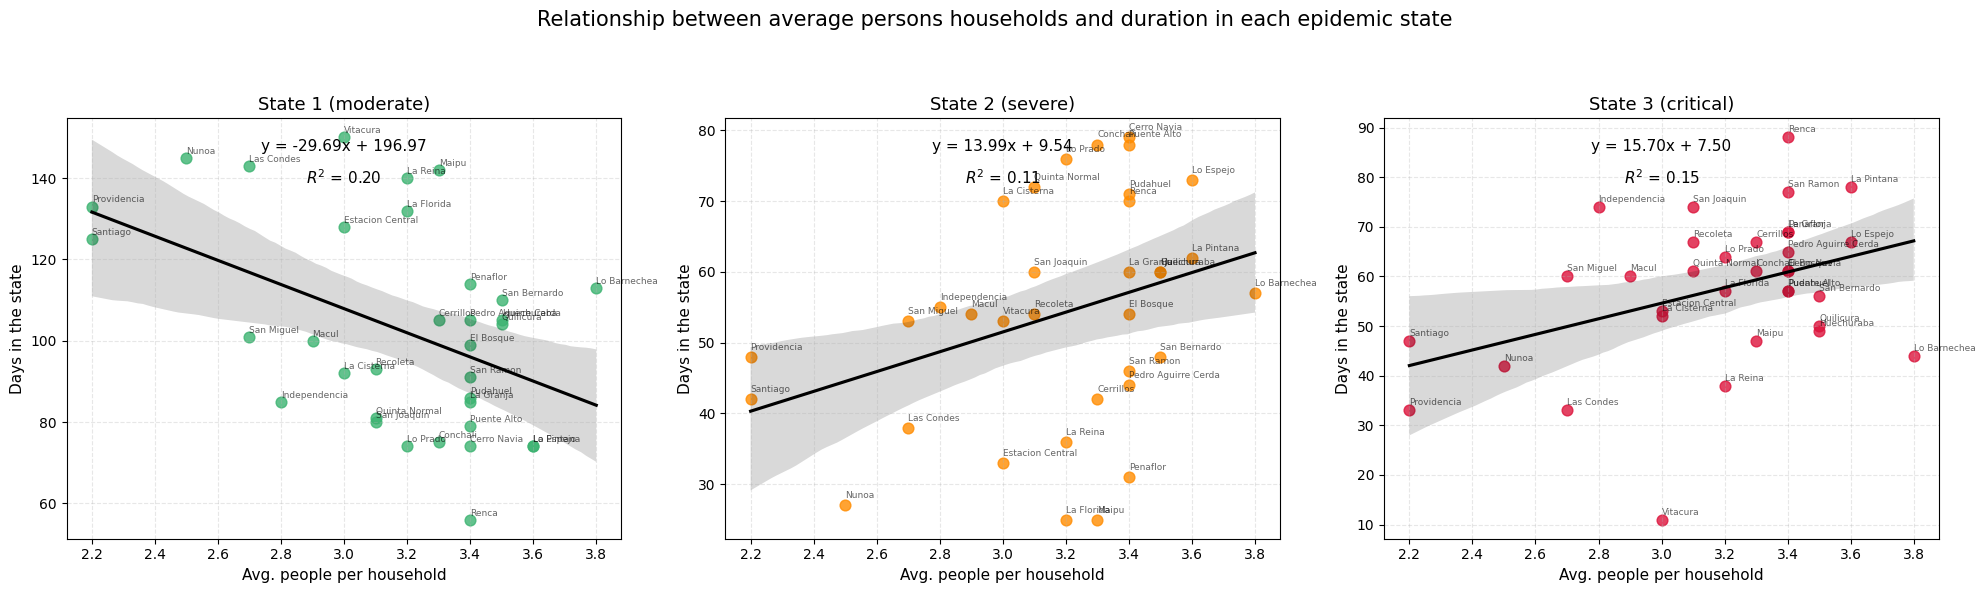

In [59]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Average_Persons_Households']
    y = df[y_col]

    # Ajuste del modelo OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Average_Persons_Households',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Average_Persons_Households'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Texto con ecuación y R² centrado arriba
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("Avg. people per household", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between average persons households and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Cantidad de días por estado con Calidad Urbana Global

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1554877189.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1554877189.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/1554877189.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

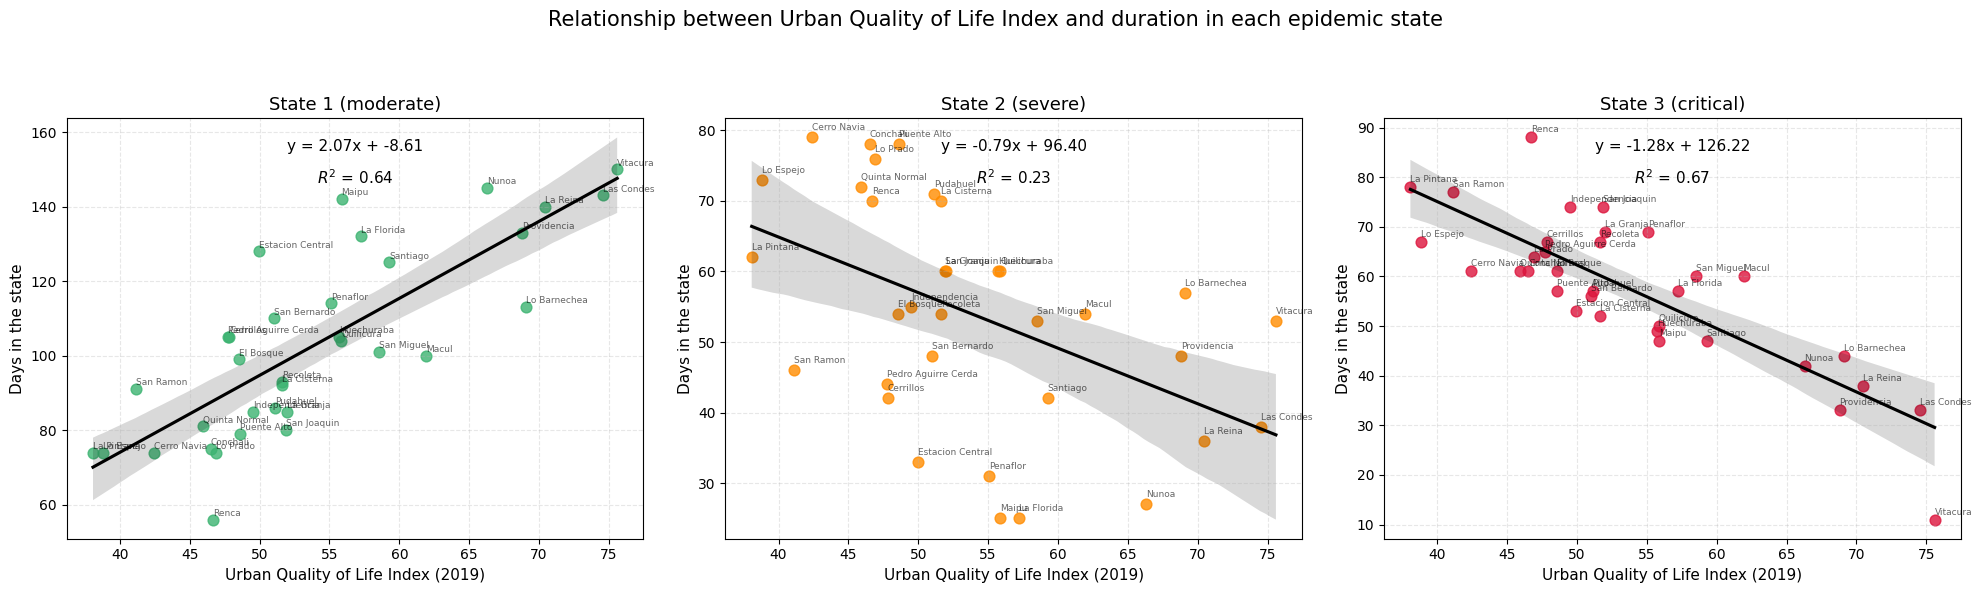

In [60]:

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Urban_Quality_of_Life_Index_2019']
    y = df[y_col]

    # Ajuste de regresión lineal con OLS
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    # Gráfico
    sns.regplot(
        data=df,
        x='Urban_Quality_of_Life_Index_2019',
        y=y_col,
        scatter_kws={'s': 60, 'alpha': 0.8},
        line_kws={'color': 'black'},
        color=colors[i],
        ax=ax
    )

    # Etiquetas de comuna
    for _, row in df.iterrows():
        ax.text(row['Urban_Quality_of_Life_Index_2019'], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

    # Anotaciones centradas
    ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
    ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

    # Títulos y ejes
    ax.set_title(state_names[state], fontsize=13)
    ax.set_xlabel("Urban Quality of Life Index (2019)", fontsize=11)
    ax.set_ylabel("Days in the state", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

# Título general
plt.suptitle("Relationship between Urban Quality of Life Index and duration in each epidemic state", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

### Cantidad de días por estado con cada dimensión de calidad urbana

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

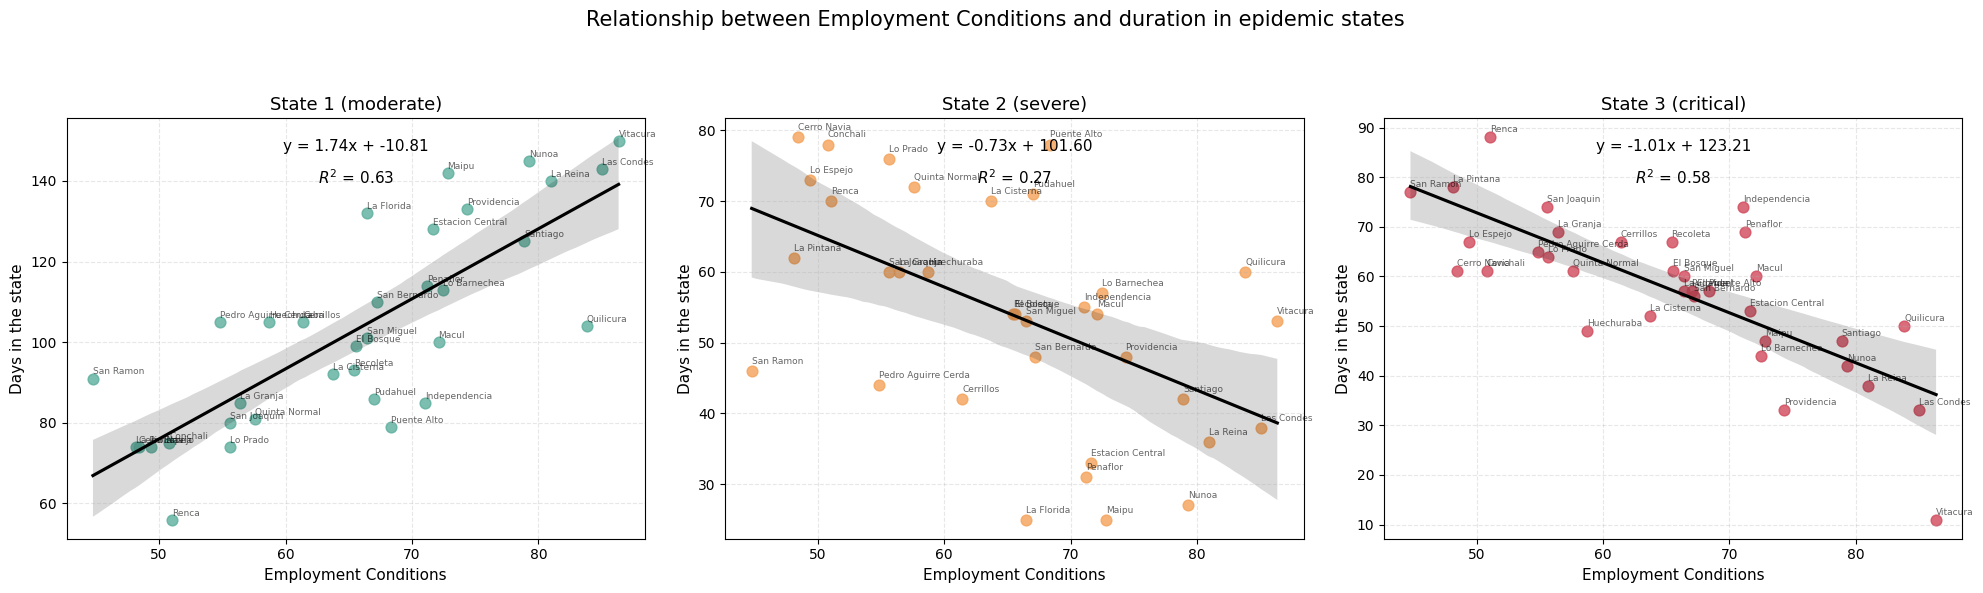

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

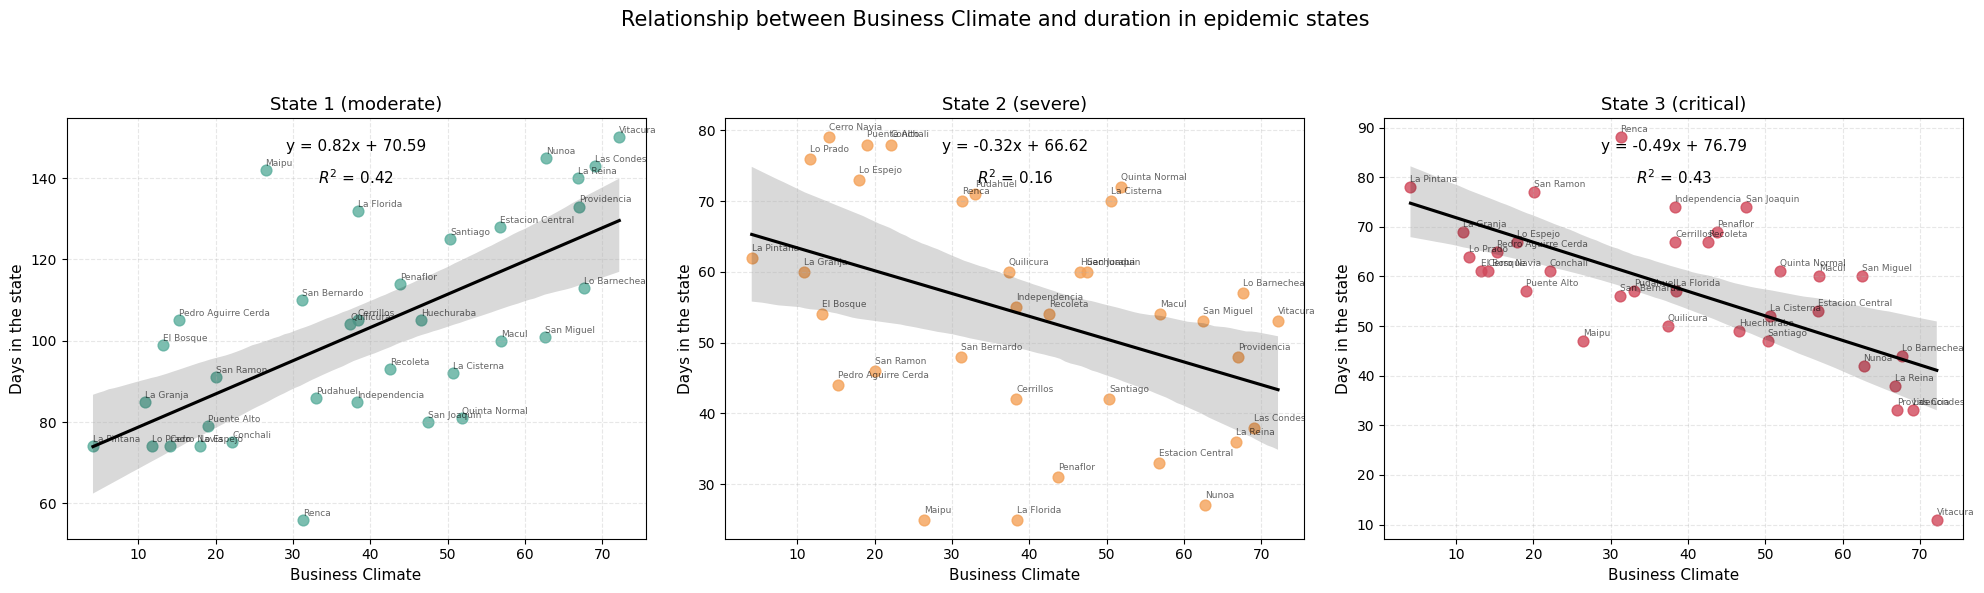

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

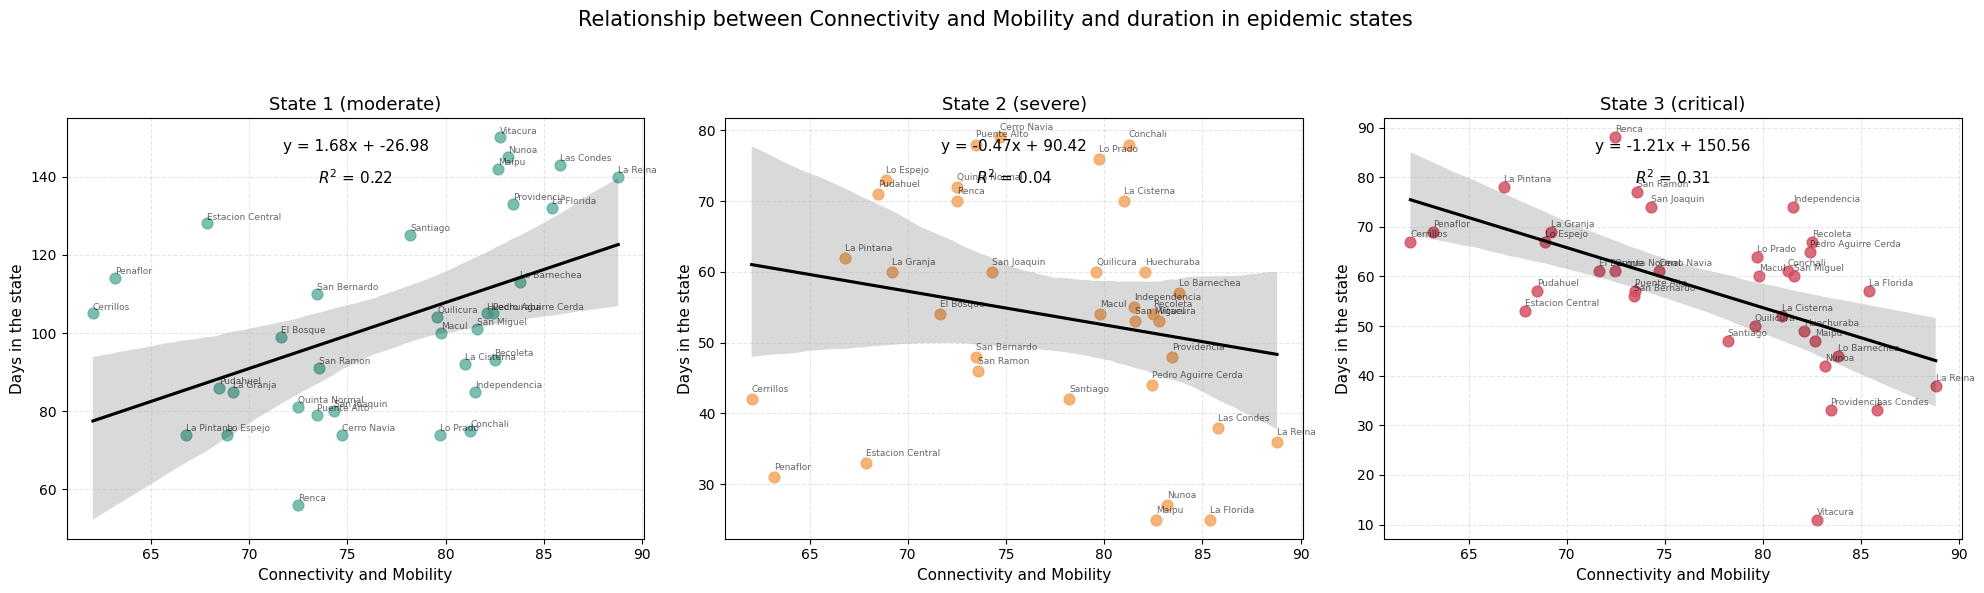

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

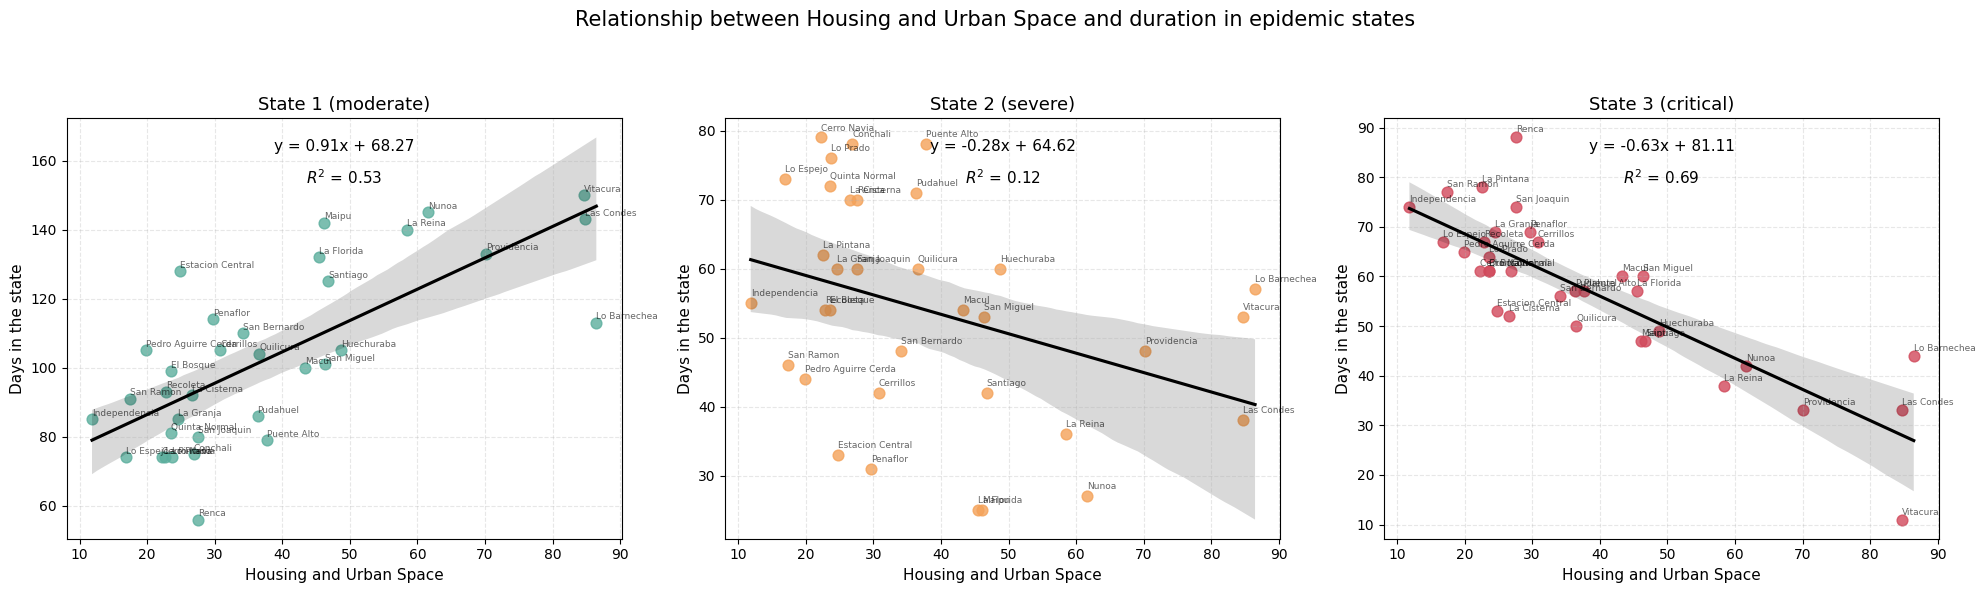

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

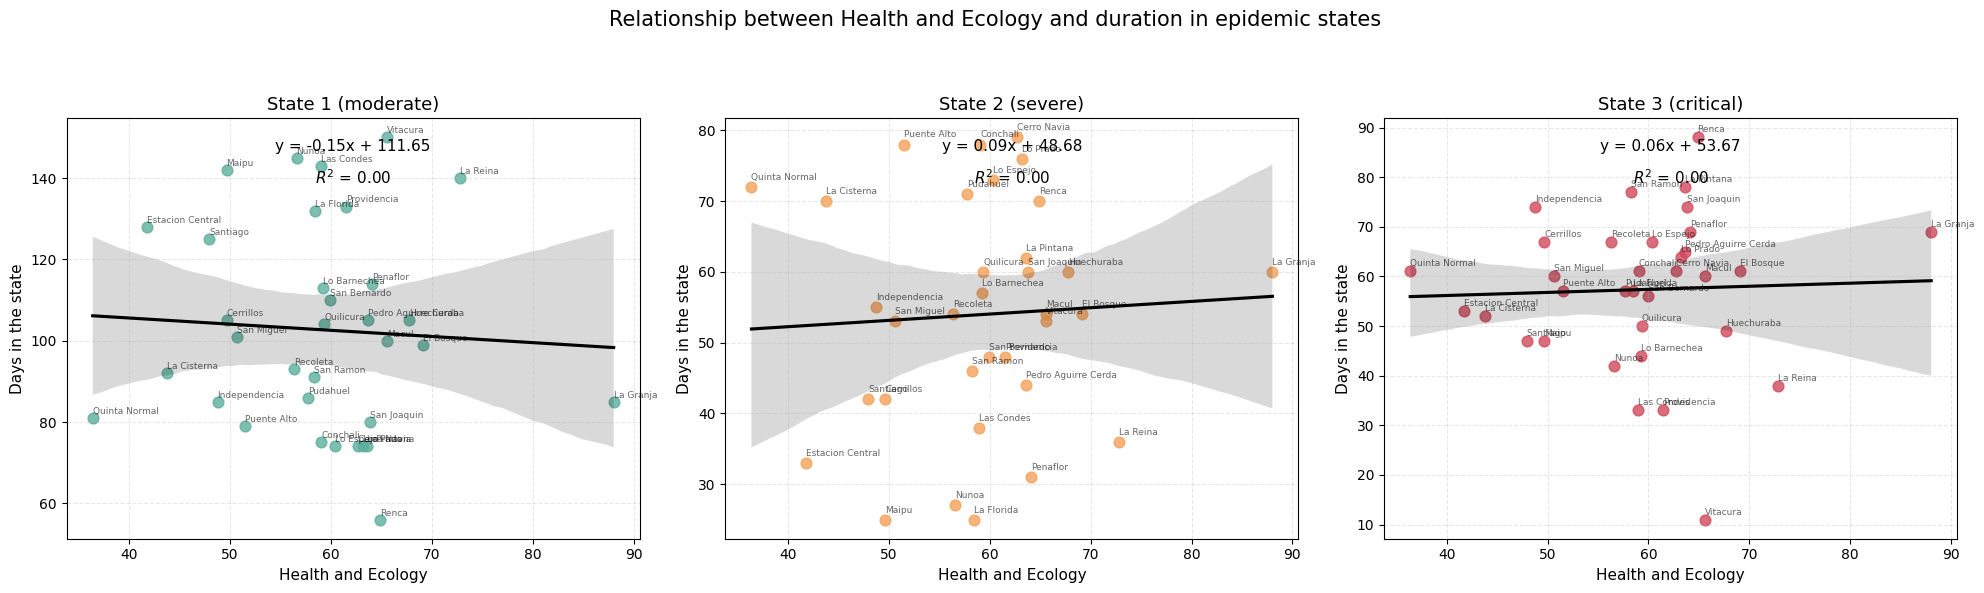

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/893003655.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

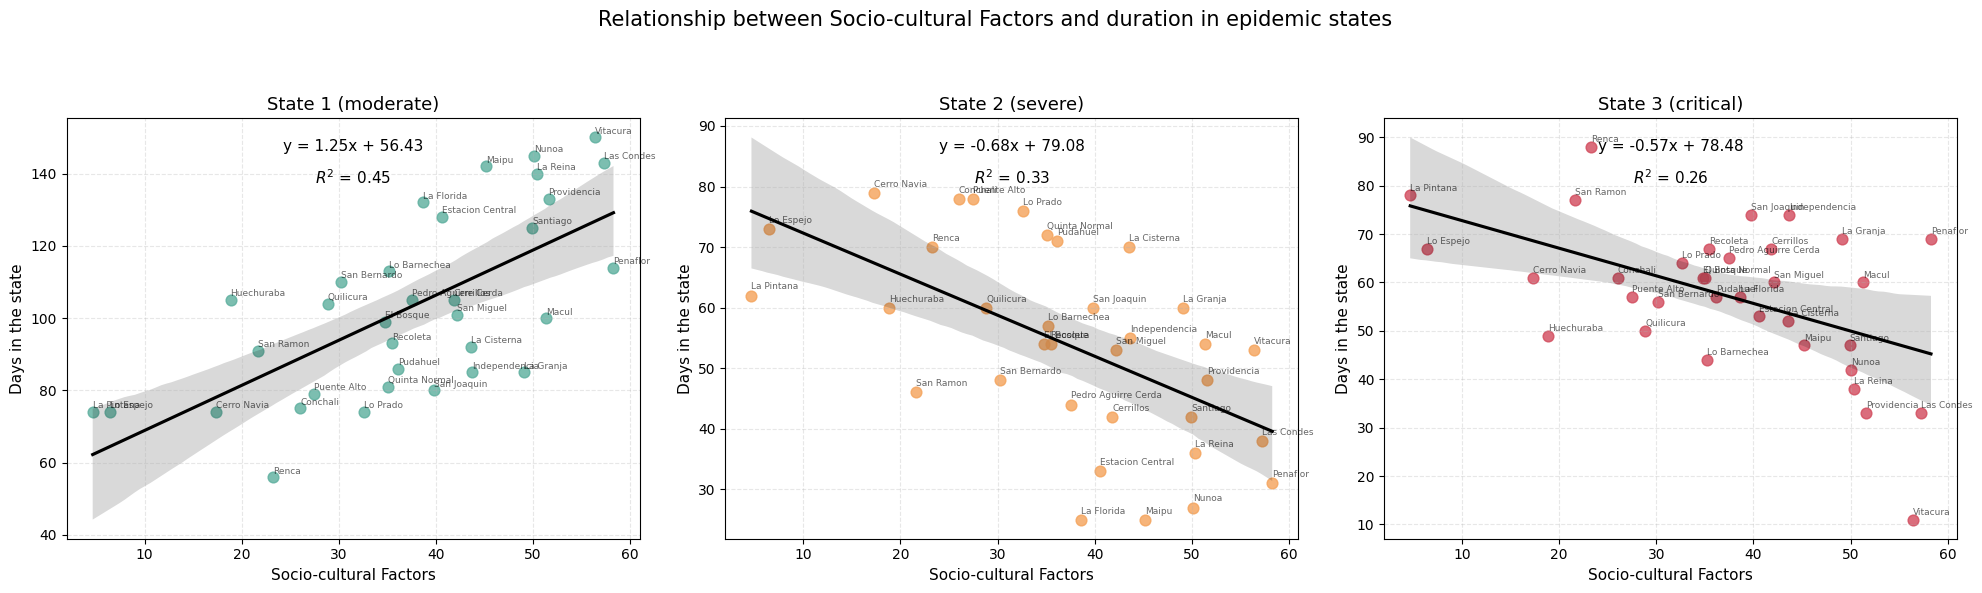

In [61]:
# 2. Variables de calidad urbana
urban_quality_vars = [
    'Employment_Conditions',
    'Business_Climate',
    'Connectivity_and_Mobility',
    'Housing_and_Urban_Space',
    'Health_and_Ecology',
    'Socio-cultural_Factors'
]

# 3. Nombres para títulos
state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}
colors = ['#5BAE9D', '#F4A259', '#D1495B']

# 4. Iterar sobre cada variable y graficar los tres estados
for urban_var in urban_quality_vars:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
    
    for i, state in enumerate([1, 2, 3]):
        ax = axes[i]
        y_col = f'Days_State_{state}'
        x = df[urban_var]
        y = df[y_col]

        # Ajuste OLS
        X_ols = sm.add_constant(x)
        model = sm.OLS(y, X_ols).fit()
        slope, intercept = model.params[1], model.params[0]
        r_squared = model.rsquared

        eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
        r_text = f"$R^2$ = {r_squared:.2f}"

        # Gráfico
        sns.regplot(
            data=df,
            x=urban_var,
            y=y_col,
            scatter_kws={'s': 60, 'alpha': 0.8},
            line_kws={'color': 'black'},
            color=colors[i],
            ax=ax
        )

        # Etiquetas de comuna
        for _, row in df.iterrows():
            ax.text(row[urban_var], row[y_col] + 1, row['Commune'], fontsize=6.5, alpha=0.6)

        # Texto centrado arriba
        ax.text(0.5, 0.95, eq_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')
        ax.text(0.5, 0.88, r_text, transform=ax.transAxes, fontsize=11, ha='center', va='top')

        ax.set_title(state_names[state], fontsize=13)
        ax.set_xlabel(urban_var.replace('_', ' '), fontsize=11)
        ax.set_ylabel("Days in the state", fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.3)

    # Título general para la variable
    plt.suptitle(f"Relationship between {urban_var.replace('_', ' ')} and duration in epidemic states", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


## Regresiones Lineales Cantidad de Días por Estado con Variable Sociodemográfica + Burbujas y Colores

### Días por Estado con IPS + Tamaño Burbujas por Ingreso Per Cápita USD

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3585655167.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3585655167.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3585655167.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

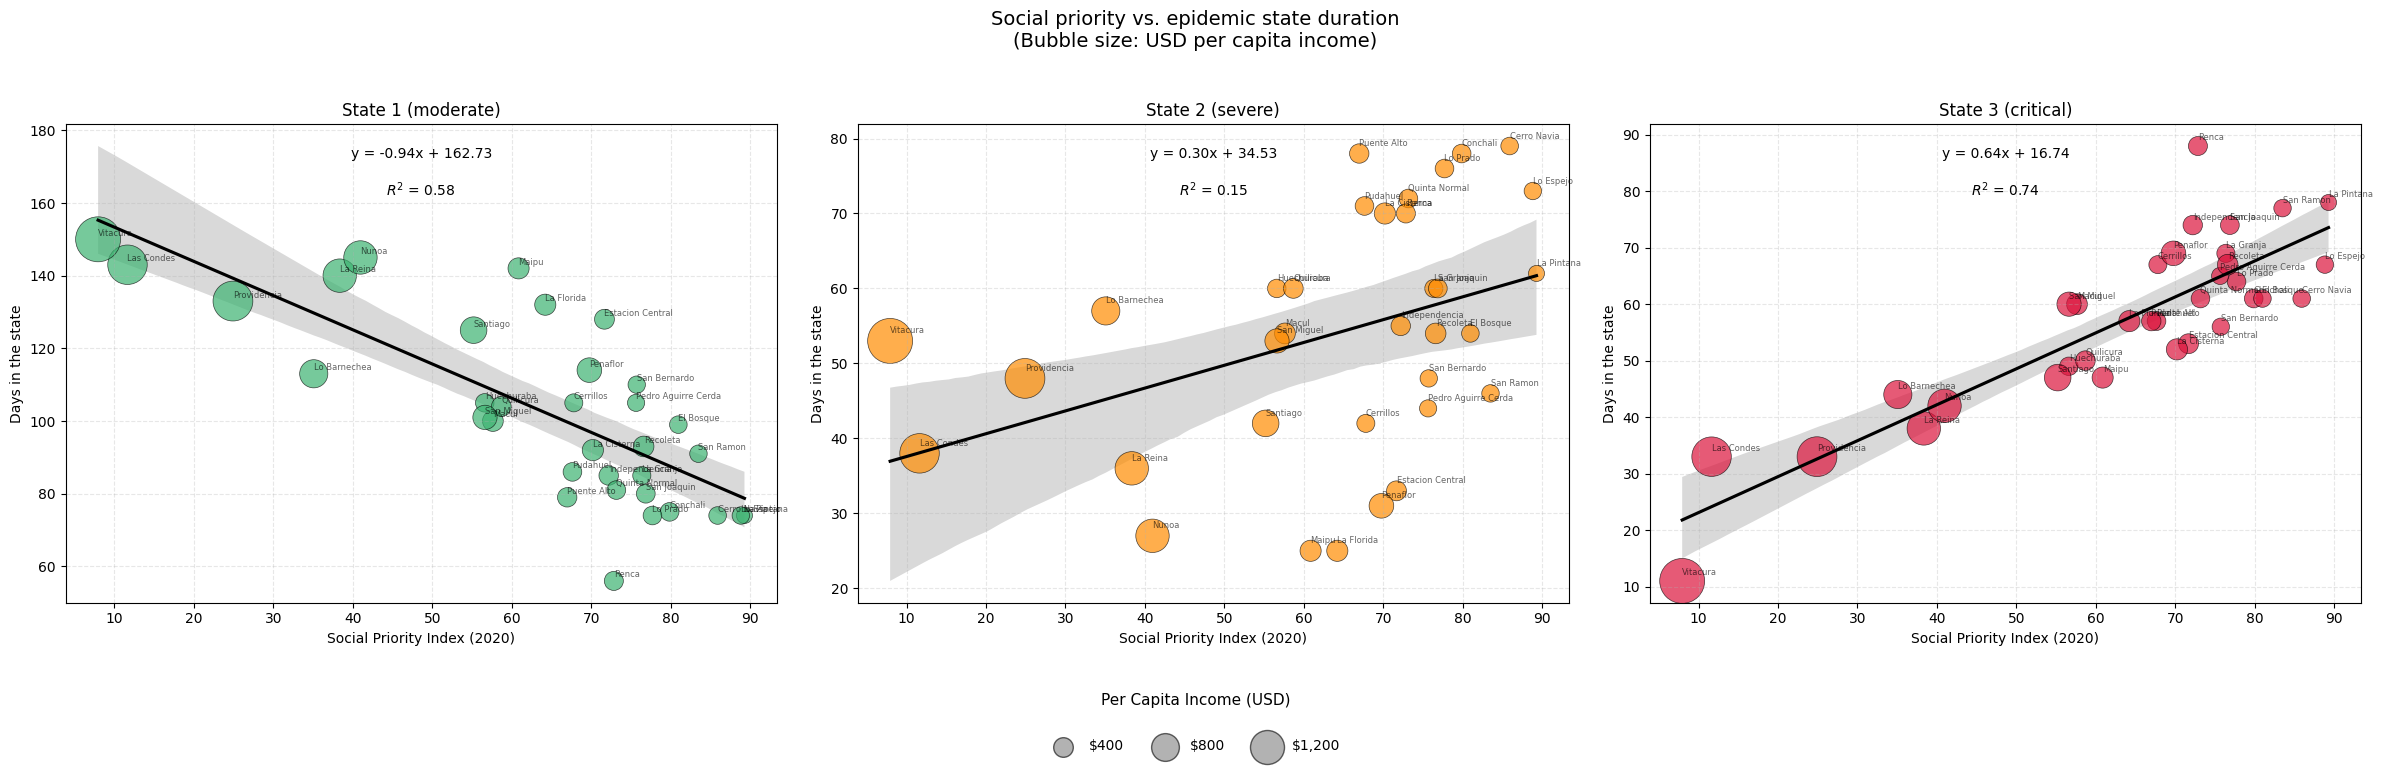

In [63]:
bubble_scale = df['USD_Per_Capita_Income'] / 2

# --- Crear figura ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Social_Priority_Index_2020']
    y = df[y_col]
    size = bubble_scale

    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    sns.regplot(
        data=df,
        x='Social_Priority_Index_2020',
        y=y_col,
        scatter=False,
        line_kws={'color': 'black'},
        ax=ax
    )

    ax.scatter(
        x, y,
        s=size,
        alpha=0.7,
        color=colors[i],
        edgecolors='black',
        linewidth=0.5
    )

    for _, row in df.iterrows():
        ax.text(row['Social_Priority_Index_2020'], row[y_col] + 1, row['Commune'], fontsize=6, alpha=0.6)

    ax.set_title(state_names[state], fontsize=12)
    ax.text(0.5, 0.93, eq_text, transform=ax.transAxes, fontsize=10, ha='center')
    ax.text(0.5, 0.85, r_text, transform=ax.transAxes, fontsize=10, ha='center')
    ax.set_xlabel("Social Priority Index (2020)", fontsize=10)
    ax.set_ylabel("Days in the state", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)

# --- Leyenda horizontal de burbujas ---
legend_sizes = [400, 800, 1200]
legend_labels = [f"${s:,}" for s in legend_sizes]
legend_handles = [
    plt.scatter([], [], s=s / 2, color='gray', alpha=0.6, edgecolors='black')
    for s in legend_sizes
]

# Creamos la leyenda manualmente y luego ajustamos la posición del título
legend = fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    title="Per Capita Income (USD)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# 🪄 Subir solo el título de la leyenda un poco
legend.get_title().set_position((0.5, 25))  # (x, y) → y más grande lo sube

# --- Título general y layout ---
plt.suptitle(
    "Social priority vs. epidemic state duration\n(Bubble size: USD per capita income)",
    fontsize=14,
    y=1.03
)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Más espacio inferior para leyenda

# --- Guardar imagen ---
output_dir = "/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_FINAL"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, "fig_social_priority_bubble.png"), dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.savefig(os.path.join(output_dir, "fig_social_priority_bubble.pdf"), bbox_inches='tight', pad_inches=0.3)

plt.show()


### Días por Estado con IUQL + Tamaño Burbujas por Ingreso Per Cápita USD

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3143864774.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3143864774.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = model.params[1], model.params[0]
/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_35668/3143864774.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

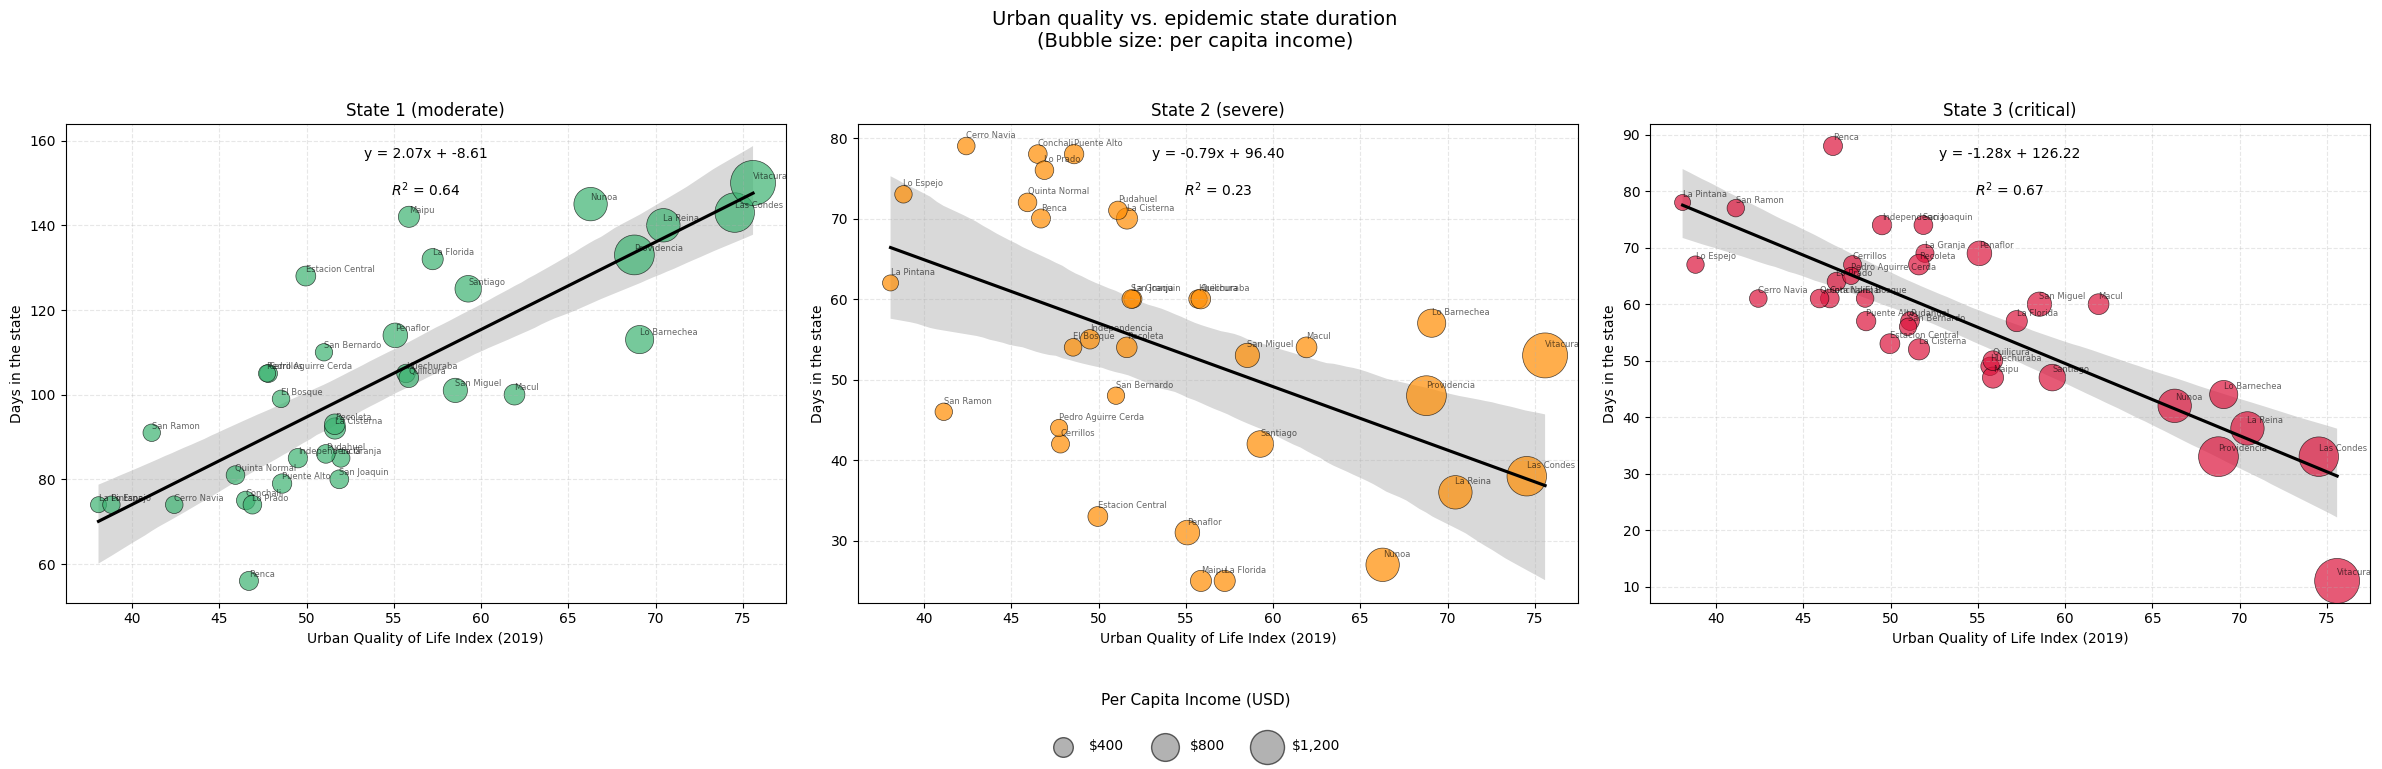

In [64]:
bubble_scale = df['USD_Per_Capita_Income'] / 2

# --- Crear figura ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=False)

state_names = {
    1: "State 1 (moderate)",
    2: "State 2 (severe)",
    3: "State 3 (critical)"
}

colors = ['mediumseagreen', 'darkorange', 'crimson']

for i, state in enumerate([1, 2, 3]):
    ax = axes[i]
    y_col = f'Days_State_{state}'
    x = df['Urban_Quality_of_Life_Index_2019']
    y = df[y_col]
    size = bubble_scale

    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    slope, intercept = model.params[1], model.params[0]
    r_squared = model.rsquared

    eq_text = f"y = {slope:.2f}x + {intercept:.2f}"
    r_text = f"$R^2$ = {r_squared:.2f}"

    sns.regplot(
        data=df,
        x='Urban_Quality_of_Life_Index_2019',
        y=y_col,
        scatter=False,
        line_kws={'color': 'black'},
        ax=ax
    )

    ax.scatter(
        x, y,
        s=size,
        alpha=0.7,
        color=colors[i],
        edgecolors='black',
        linewidth=0.5
    )

    for _, row in df.iterrows():
        ax.text(row['Urban_Quality_of_Life_Index_2019'], row[y_col] + 1, row['Commune'], fontsize=6, alpha=0.6)

    ax.set_title(state_names[state], fontsize=12)
    ax.text(0.5, 0.93, eq_text, transform=ax.transAxes, fontsize=10, ha='center')
    ax.text(0.5, 0.85, r_text, transform=ax.transAxes, fontsize=10, ha='center')
    ax.set_xlabel("Urban Quality of Life Index (2019)", fontsize=10)
    ax.set_ylabel("Days in the state", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)

# --- Leyenda horizontal de burbujas ---
legend_sizes = [400, 800, 1200]
legend_labels = [f"${s:,}" for s in legend_sizes]
legend_handles = [
    plt.scatter([], [], s=s / 2, color='gray', alpha=0.6, edgecolors='black')
    for s in legend_sizes
]

legend = fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    title="Per Capita Income (USD)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# 🪄 Subir solo el título de la leyenda un poco
legend.get_title().set_position((0.5, 25))  # (x, y)

# --- Título general y layout ---
plt.suptitle(
    "Urban quality vs. epidemic state duration\n(Bubble size: per capita income)",
    fontsize=14,
    y=1.03
)
plt.tight_layout(rect=[0, 0.1, 1, 1])

# --- Guardar imagen ---
output_dir = "/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_FINAL"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, "fig_urban_quality_bubble.png"), dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.savefig(os.path.join(output_dir, "fig_urban_quality_bubble.pdf"), bbox_inches='tight', pad_inches=0.3)

plt.show()


### Con R

#r('''install.packages(c("ggplot2", "cowplot", "scales", "gridExtra"))''')

#r('''install.packages("ggrepel")''')


In [65]:
# Asegúrate de tener `df` con los datos procesados
import pandas as pd
from rpy2.robjects import pandas2ri, r

# Activar conversión automática
pandas2ri.activate()
r_df = pandas2ri.py2rpy(df)
r.assign("df", r_df)

# Ruta de guardado
r('output_dir <- "/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/FINAL_MAYO/VISUALIZACIÓN_LIMPIA"')


### Días Permanencia Estado con Prioridad Social, más intensidad color según precariedad de la vivienda y tamaño burbuja según ingreso.

- Figura 3 se ve bien estéticamente, pero tiene la fórmula a lo largo, y el profe sugirió bajar el R2, para que ocupara más espacio del espacio blanco. A mi juicio estéticamente es uno de los mejores, pero no aparecen todas las etiquetas de las comunas, aunque revisé el del profe del paper y tampoco salen, por eso quizás es mejor porque se ve más limpio, así que lo dejo por si acaso.

In [66]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)

# --- Paletas personalizadas ---
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Housing Precariousness Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Housing Precariousness Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Housing Precariousness Index")
)

state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# --- Función para graficar un subplot ---
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp

  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq_full <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2),
                    "     R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(8, 16, 8, 16)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income,
                   fill = Housing_Precariousness_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    geom_text(aes(label = Commune), size = 3.5, vjust = -1.2, nudge_x = -5, check_overlap = TRUE) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq_full, hjust = 0.3, vjust = 1.5, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(5, 15),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# --- Crear gráficos por estado ---
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# --- Extraer leyendas ---
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# --- Leyenda de tamaño (centrada) ---
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# --- Quitar leyendas de los gráficos principales ---
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# --- Ensamblar panel principal ---
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# --- Añadir letras (A), (B), (C) en cada subplot ---
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# --- Leyendas alineadas ---
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3, rel_widths = c(1, 1, 1))
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# --- Composición final ---
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# --- Exportar a archivo ---
ggsave(file.path(output_dir, "fig_3.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.6)
ggsave(file.path(output_dir, "fig_3.png"), final_plot,
       dpi = 600, width = 21, height = 8.6)
''')


R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.hadley.nz/

R[write to console]: 
Adjuntando el paquete: ‘dplyr’


R[write to console]: The following object is masked from ‘package:nlme’:

    collapse


R[write to console]: The following object is masked from ‘package:MASS’:

    select


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Adjuntando el paquete: ‘ggpubr’


R[write to console]: The following object is masked from ‘package:cowplot’:

    get_legend




`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Prioridad Social, más intensidad color según precariedad de la vivienda y tamaño burbuja según ingreso (el mismo anterior).

- Figura 7 se ve bien estéticamente, fórmula con dos líneas y más grande, con todas las etiquetas, no se escapan las etiquetas de algunas comunas porque ajusta las etiquetas con la librería ggrepel. Aparecen algunas comunas que tienen una línea que las une con la burbuja, como para identificar qué comuna es cada burbuja en las que no están muy claro, no me gusta mucho pero lo dejo por si acaso.

In [67]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)  # <--- NUEVO

# Colores por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Housing Precariousness Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Housing Precariousness Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Housing Precariousness Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Housing_Precariousness_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = "grey50", segment.size = 0.3) +  # <--- NUEVO
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# Extraer leyendas
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# Leyenda tamaño
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Limpiar subplots para ensamblar
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# Ensamblar panel
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# Letras A B C
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_7.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_7.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Prioridad Social, más intensidad color según precariedad de la vivienda y tamaño burbuja según ingreso (el mismo anterior).

- Figura 8 se ve bien estéticamente, con todas las etiquetas, no se escapan las etiquetas de algunas comunas porque ajusta las etiquetas con la librería ggrepel. Le saqué las líneas que unen burbuja con comunas.

In [68]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)  # <--- NUEVO

# Colores por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Housing Precariousness Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Housing Precariousness Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Housing Precariousness Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Housing_Precariousness_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +  # <--- NUEVO
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# Extraer leyendas
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# Leyenda tamaño
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(5, 15),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Limpiar subplots para ensamblar
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# Ensamblar panel
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# Letras A B C
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_8.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_8.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Prioridad Social, más intensidad color según promedio de casos y tamaño burbuja según ingreso.

In [69]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Colores por estado para casos
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "7-Day Avg. Daily Cases"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "7-Day Avg. Daily Cases"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "7-Day Avg. Daily Cases")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Gross_Daily_Cases_Mobile_Average_7_Days),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# Extraer leyendas
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(5, 15),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Limpiar subplots
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# Ensamblar panel
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# Letras A B C
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_casos_1.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_casos_1.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Prioridad Social, más intensidad color según movilidad interna y tamaño burbuja según ingreso.

In [70]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Colores por estado para movilidad interna
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Internal Mobility Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Internal Mobility Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Internal Mobility Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Internal_Mobility_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(5, 15),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# Extraer leyendas de color
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(5, 15),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Subplots sin leyenda para ensamblar
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# Panel principal
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# Letras A B C
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas unificadas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Ensamble final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_mobility_interna_1.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_mobility_interna_1.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Prioridad Social, más intensidad color según movilidad externa y tamaño burbuja según ingreso.

In [71]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Colores por estado para movilidad externa
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "External Mobility Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "External Mobility Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "External Mobility Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = External_Mobility_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE)

# Extraer leyendas de color
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(5, 15),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Subplots sin leyenda para ensamblar
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")

# Panel principal
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))

# Letras A B C
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas unificadas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Ensamble final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_mobility_externa_1.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_mobility_externa_1.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Días Permanencia Estado con Índice de Calidad Urbana, más intensidad color según promedio de casos y tamaño burbuja según ingreso.

In [72]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "7-Day Avg. Daily Cases"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "7-Day Avg. Daily Cases"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "7-Day Avg. Daily Cases")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para cada gráfico
make_plot <- function(state_var, title_text, eq_x, eq_y, r2_y, state_index, hjust_val = 0, show_legend = FALSE, hide_y = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Urban_Quality_of_Life_Index_2019, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank())
  }

  ggplot(df_temp, aes(x = Urban_Quality_of_Life_Index_2019, y = Y)) + xlim(36, NA) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Gross_Daily_Cases_Mobile_Average_7_Days),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = hjust_val, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * r2_y, label = r2, hjust = hjust_val, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(5, 15),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Urban Quality of Life Index (2019)",
         y = "Days in the state") +
    base_theme
}

# Subplots (ajustado para alinear fórmulas correctamente)
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)",
                    eq_x = 36, eq_y = 1.15, r2_y = 1.05,
                    state_index = 1, hjust_val = 0, show_legend = TRUE)

g2_leg <- make_plot("Days_State_2", "State 2 (severe)",
                    eq_x = 74, eq_y = 1.05, r2_y = 0.94,
                    state_index = 2, hjust_val = 1, show_legend = TRUE, hide_y = TRUE)

g3_leg <- make_plot("Days_State_3", "State 3 (critical)",
                    eq_x = 74, eq_y = 1.05, r2_y = 0.94,
                    state_index = 3, hjust_val = 1, show_legend = TRUE, hide_y = TRUE)

# Leyendas
legend_fill_1 <- get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- get_legend(g3_leg + guides(size = "none"))

legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(color = "gray40") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(5, 15),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- get_legend(legend_size_plot)

# Paneles
g1 <- g1_leg + theme(legend.position = "none")
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none")
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv")

panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Ensamble final
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "fig_urban_quality_casos_final_mejor1.pdf"), final_plot,
       dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "fig_urban_quality_casos_final_mejor1.png"), final_plot,
       dpi = 600, width = 21, height = 8.8)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


# HASTA AQUÍ ESTÁ EJECUTADO OKEY Y LIMPIO

## Transition probabilites between states:

In [ ]:
# Extract the adjusted transition matrix
transition_matrix = r['slot'](hmm_fitted, "trDens")
print("\nAdjusted transition matrix:")
print(transition_matrix)


Adjusted transition matrix:
[[[9.88006681e-01 1.91888104e-03 7.73190168e-03]
  [1.05865720e-02 9.98081119e-01 1.69924865e-09]
  [1.40674676e-03 3.67625285e-16 9.92268097e-01]]

 [[9.81706807e-01 8.73606558e-04 8.87355680e-03]
  [1.75687684e-02 9.99126393e-01 2.41835625e-09]
  [7.24424308e-04 3.99844055e-17 9.91126441e-01]]

 [[9.62216407e-01 2.39731211e-04 1.01469551e-02]
  [3.75528065e-02 9.99760269e-01 3.91683534e-09]
  [2.30786421e-04 1.16159822e-18 9.89853041e-01]]

 ...

 [[2.16388780e-04 2.64861839e-11 4.27939964e-07]
  [2.62212712e-14 9.60740041e-20 2.18025280e-15]
  [9.99783611e-01 1.00000000e+00 9.99999572e-01]]

 [[1.98407498e-04 2.49488917e-11 4.48450043e-07]
  [2.39088527e-14 8.43894619e-20 2.24904641e-15]
  [9.99801593e-01 1.00000000e+00 9.99999552e-01]]

 [[9.83970738e-05 1.49492932e-11 6.45279779e-07]
  [1.11792612e-14 2.85247699e-20 2.84130650e-15]
  [9.99901603e-01 1.00000000e+00 9.99999355e-01]]]


In [ ]:
# Restructure transition_matrix to obtain transition probabilities per sample
n_samples, n_states, _ = transition_matrix.shape

# Remapping state indexes
transitions_list = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix[t, i, j]  
            })

transitions_df = pd.DataFrame(transitions_list).groupby("sample").mean().reset_index(drop=True)

# Reordering State Transitions:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

# Apply transitions name mapping
transitions_df = transitions_df.rename(columns=remap_transition_states)



print("Structured transitions:")
print(transitions_df.head())


Structured transitions:
   Trans_2->2  Trans_2->3  Trans_2->1  Trans_3->2  Trans_3->3    Trans_3->1  \
0    0.988007    0.001919    0.007732    0.010587    0.998081  1.699249e-09   
1    0.981707    0.000874    0.008874    0.017569    0.999126  2.418356e-09   
2    0.962216    0.000240    0.010147    0.037553    0.999760  3.916835e-09   
3    0.984126    0.003281    0.015371    0.012664    0.996719  3.049639e-09   
4    0.890539    0.000056    0.017375    0.109388    0.999944  1.016508e-08   

   Trans_1->2    Trans_1->3  Trans_1->1  
0    0.001407  3.676253e-16    0.992268  
1    0.000724  3.998441e-17    0.991126  
2    0.000231  1.161598e-18    0.989853  
3    0.003209  6.806549e-16    0.984629  
4    0.000072  1.358643e-20    0.982625  


In [ ]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'CUT', 'Comuna', 'Población', 'Densidad_Pob_Km2',
       'Total_Viviendas', 'Cantidad_Hogares', 'Porc_Hacinamiento',
       'Promedio_Personas_Hogar', 'Porc_Ed_Superior_Terminada',
      

In [ ]:
# Selecting relevant covariates
covariates_df = viterbi_merged[[
    'Internal_Mobility_Index', 'External_Mobility_Index', 
    'Per_Capita_Income', 'Average_Household_Persons', 'Inmigrants', 
    'Total_Households_Housed', 'Housing_Precariousness_Index', 
    'Higher_Education_Percentage', 'Social_Priority_Index_2020',
    'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019', 
       'Densidad_Pob_Km2',
       'Total_Viviendas', 'Cantidad_Hogares', 'Porc_Hacinamiento',
       'Promedio_Personas_Hogar', 'Porc_Ed_Superior_Terminada',
       'Porc_Hogares_con_Migrantes'
]].reset_index(drop=True)

# Combine with transitions
analysis_df = pd.concat([covariates_df, transitions_df], axis=1)
print("Combined data for analysis:")
print(analysis_df.head())

Combined data for analysis:
   Internal_Mobility_Index  External_Mobility_Index  Per_Capita_Income  \
0                 1.970381                 7.804008          267197.56   
1                 1.845790                 7.471452          267197.56   
2                 1.678598                 6.891732          267197.56   
3                 1.736766                 8.317872          267197.56   
4                 1.331296                 6.378498          267197.56   

   Average_Household_Persons  Inmigrants  Total_Households_Housed  \
0                   3.145581        3606                    68120   
1                   3.145581        3606                    68120   
2                   3.145581        3606                    68120   
3                   3.145581        3606                    68120   
4                   3.145581        3606                    68120   

   Housing_Precariousness_Index  Higher_Education_Percentage  \
0                      3.395792                 

In [ ]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Connectivity_and_Mobility', 'Housing_and_Environment',
       'Labor_Conditions', 'Business_Environment', 'Health_and_Environment',
       'Socio_cultural_conditions', 'Urban_Quality_of_Life_Index_2024',
       'Reordened_state'],
      dtype='object')

In [ ]:

transitions = []


for idx, matriz in enumerate(transition_matrix):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transitions.append({
                'Original_Day':  viterbi_merged.iloc[idx]['Days'],  # Original day on final basis
                'Correlative_Day': idx,  # Index or correlative day generated
                'Commune': viterbi_merged.iloc[idx]['Commune'],  # Commune associated to the day
                'from_state': from_state + 1,  
                'to_state': to_state + 1,     
                'probability': matriz[from_state][to_state]
            })

transitions_df = pd.DataFrame(transitions)

transitions_df['Transition'] = (
    "Trans_" + transitions_df['from_state'].astype(str) + "->" + transitions_df['to_state'].astype(str)
)




In [ ]:
transitions_df.head()

Original_Day  Correlative_Day    Commune  from_state  to_state  probability  \
0   2020-04-02                0  Cerrillos           1         1     0.988007   
1   2020-04-02                0  Cerrillos           1         2     0.001919   
2   2020-04-02                0  Cerrillos           1         3     0.007732   
3   2020-04-02                0  Cerrillos           2         1     0.010587   
4   2020-04-02                0  Cerrillos           2         2     0.998081   

   Transition  
0  Trans_1->1  
1  Trans_1->2  
2  Trans_1->3  
3  Trans_2->1  
4  Trans_2->2

In [ ]:
# Rearrange the states to match the desired interpretation:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

transitions_df['Reordened_Transition'] = transitions_df['Transition'].map(remap_transition_states)

In [ ]:
# Pivot to have the transitions as columns
transitions_df = transitions_df.pivot(
    index=['Commune', 'Original_Day', 'Correlative_Day'],  # Add both day references
    columns='Reordened_Transition',
    values='probability'
).reset_index()


print("DataFrame of transitions updated:")
print(transitions_df.head())


DataFrame of transitions updated:
Reordened_Transition    Commune Original_Day  Correlative_Day  Trans_1->1  \
0                     Cerrillos   2020-04-02                0    0.992268   
1                     Cerrillos   2020-04-03                1    0.991126   
2                     Cerrillos   2020-04-04                2    0.989853   
3                     Cerrillos   2020-04-05                3    0.984629   
4                     Cerrillos   2020-04-06                4    0.982625   

Reordened_Transition  Trans_1->2    Trans_1->3  Trans_2->1  Trans_2->2  \
0                       0.001407  3.676253e-16    0.007732    0.988007   
1                       0.000724  3.998441e-17    0.008874    0.981707   
2                       0.000231  1.161598e-18    0.010147    0.962216   
3                       0.003209  6.806549e-16    0.015371    0.984126   
4                       0.000072  1.358643e-20    0.017375    0.890539   

Reordened_Transition  Trans_2->3    Trans_3->1  Trans_3->2

In [ ]:
transitions_df.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Trans_1->1',
       'Trans_1->2', 'Trans_1->3', 'Trans_2->1', 'Trans_2->2', 'Trans_2->3',
       'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
      dtype='object', name='Reordened_Transition')

In [ ]:
# Convert transitions to “long” format
transitions_long = pd.melt(
    transitions_df,
    id_vars=['Commune', 'Original_Day', 'Correlative_Day'],  # Include both columns of days
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
    var_name='Transition',
    value_name='Probability_Transition'
)

# Perform the merge to add the covariables from base_final
lmm_data = transitions_long.merge(
    viterbi_merged[['Commune', 'Days', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
                'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed', 
                'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020',
                'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019', 
       'Densidad_Pob_Km2',
       'Total_Viviendas', 'Cantidad_Hogares', 'Porc_Hacinamiento',
       'Promedio_Personas_Hogar', 'Porc_Ed_Superior_Terminada',
       'Porc_Hogares_con_Migrantes']],
    left_on=['Commune', 'Original_Day'],  # Use Original_day to match base_final
    right_on=['Commune', 'Days'],         # The column in base_final is ‘days’.
    how='left'
)


print("Data prepared for LMM (in long format with additional covariates):")
print(lmm_data.head())


Data prepared for LMM (in long format with additional covariates):
     Commune Original_Day  Correlative_Day  Transition  \
0  Cerrillos   2020-04-02                0  Trans_1->1   
1  Cerrillos   2020-04-03                1  Trans_1->1   
2  Cerrillos   2020-04-04                2  Trans_1->1   
3  Cerrillos   2020-04-05                3  Trans_1->1   
4  Cerrillos   2020-04-06                4  Trans_1->1   

   Probability_Transition       Days  Internal_Mobility_Index  \
0                0.992268 2020-04-02                 1.970381   
1                0.991126 2020-04-03                 1.845790   
2                0.989853 2020-04-04                 1.678598   
3                0.984629 2020-04-05                 1.736766   
4                0.982625 2020-04-06                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  ...  \
0                 7.804008               2.248303           2.248303  ...   
1                 7.471452             

In [ ]:
lmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Commune                                  65484 non-null  object        
 1   Original_Day                             65484 non-null  datetime64[ns]
 2   Correlative_Day                          65484 non-null  int64         
 3   Transition                               65484 non-null  object        
 4   Probability_Transition                   65484 non-null  float64       
 5   Days                                     65484 non-null  datetime64[ns]
 6   Internal_Mobility_Index                  65484 non-null  float64       
 7   External_Mobility_Index                  65484 non-null  float64       
 8   Cumulative_Cases_Rate                    65484 non-null  float64       
 9   Gross_Daily_Cases                      

In [ ]:
lmm_data.to_csv(
    "/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/MAYO/lmm_data.csv",
    index=False
)


# AQUÍ GUARDÉ LA NUEVA DATA CON CAMBIOS LISTA PARA LMM
